In [67]:
#install.packages("prediction")

In [2]:
library(MASS)
library(dplyr)
library(ggplot2)
library(boot)
library(stargazer)
#library(GGally)
library(rio)
library(readr)
library(tidyverse)

library(devtools)
library(caret)
library(broom)
library(corrr)

library(plotly)
library(sp) # make spatial plots

library(sandwich)  # obtain the robust standard errors 
library(glmnet)    # penalized linear regression models.
library(rsample)   # contains initial_split function
library(car)       # has the vif function and partial residual plots
library(plm)       # Panel data analysis library
library(gplots)    # Various programing tools for plotting data
library(tseries)   # For timeseries analysis
library(lmtest)    # For hetoroskedasticity analysis
library(glmmLasso) # LASSO in linear mixed models
library(Metrics)   # calculates the RMSE
library(prediction)# predicts from GLMMs
library(lme4)      # for poisson regression in panel datasets
library(fields)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

Loading required package: usethis

Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:boot’:

    melanoma



At

In [3]:
pnwbig = load("pnw-bigfoot.rdata")
head(pnwbig)

[1] "bigfoot"          "idaho"            "wash.oregon.spdf" "idaho.spdf"

In [70]:
bigfoot %>% filter(County == "Adams")

Decade    STCOU State      County Population SqMi    Elev   Water      
1 1958-1967 53001 Washington Adams   9929      1929.73 440.44 0.002786275
2 1968-1977 53001 Washington Adams  12108      1929.73 440.44 0.002786275
3 1978-1987 53001 Washington Adams  13264      1929.73 440.44 0.002786275
4 1988-1997 53001 Washington Adams  13612      1929.73 440.44 0.002786275
5 1998-2007 53001 Washington Adams  16426      1929.73 440.44 0.002786275
6 2008-2017 53001 Washington Adams  18728      1929.73 440.44 0.002786275
  Developed  Snow.Barren  ⋯ Grass.Shrub Agriculture Wetlands   Seattle 
1 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
2 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
3 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
4 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
5 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
6 0.03068557 5.941268e-05 ⋯ 0.3882788   0.5681543   0.00988609 293.4768
  Portland Boise    Vancouver Lon       Lat      Bigfoot
1 293.4768 293.4768 293.4768  -118.5611 46.98333 0      
2 293.4768 293.4768 293.4768  -118.5611 46.98333 0      
3 293.4768 293.4768 293.4768  -118.5611 46.98333 0      
4 293.4768 293.4768 293.4768  -118.5611 46.98333 0      
5 293.4768 293.4768 293.4768  -118.5611 46.98333 0      
6 293.4768 293.4768 293.4768  -118.5611 46.98333 0

I have scrutinized the relationship between various geographic features and the counts of bigfoot or Sasquatch sightings observed not only at both state and county-level, but also at decade-level.  The data comprises of the reported number of bigfoots sighted in the Pacific Northwestern from 1968-2017, specifically in the states of Washington, and Oregon. 

In the entire dataset, the time-invariant variables are the five variables measuring distance characterstics including the spatial location via lat and lon variables. Moreover, the names of the states and counties are time-invariant as they are constant over time. Alternatively, the land characterstics and the number of bigfoot sightings are time-dependent covariates.

From the bigfoot dataset with measures of bigfoot sightings in Oregon and Washington, the summary statistics of the land characterstics variables show that the proportions very minutely change over time, as also evident from the very low standard deviations. Due to the high volatility of the variable population (sd = 203,648.5), I transformed it by taking its log to reduce the deviation from its mean.

In [10]:
bigfoot_subset = bigfoot %>% select(Bigfoot, Population, Water, Developed, Forest, Agriculture, Wetlands, 
                              Snow.Barren, Grass.Shrub, Decade, State)
stargazer(bigfoot_subset, type = 'text')


Statistic    N     Mean     St. Dev.     Min   Pctl(25) Pctl(75)    Max   
--------------------------------------------------------------------------
Bigfoot     450   1.436       2.791       0       0        2        21    
Population  450 99,051.330 203,648.500  1,400  13,825.8 78,420.2 1,931,249
Water       450   0.014       0.020    0.0005   0.005    0.016     0.171  
Developed   450   0.063       0.065     0.006   0.023    0.074     0.289  
Forest      450   0.419       0.244    0.0001   0.223    0.614     0.783  
Agriculture 450   0.144       0.165     0.002   0.025    0.259     0.715  
Wetlands    450   0.023       0.022     0.001   0.008    0.032     0.090  
Snow.Barren 450   0.009       0.015    0.00000  0.0004   0.010     0.080  
Grass.Shrub 450   0.327       0.218     0.033   0.146    0.481     0.936  
--------------------------------------------------------------------------


Below, I have summarized the number of bigfoots sighted in each decade. Over time, the average reported signtings have rised, reaching the peak to 3.547 in 1998-2007 before falling to 1.547, albeit the maximum of bigfoots were reportedly sighted in 2008-2017.

In [106]:
sum_decade = bigfoot %>% 
  group_by(Decade) %>% 
  summarize(
            min = min(Bigfoot),
            q1 = quantile(Bigfoot, 0.25),
            mean = mean(Bigfoot),
            q3 = quantile(Bigfoot, 0.75),
            max = max(Bigfoot)) %>% as.data.frame()

stargazer(sum_decade, type = "text", summary = FALSE,
                title="Summary Statistics of the Reported Number of Bigfoots Sighted by Decade ")

`summarise()` ungrouping output (override with `.groups` argument)




Summary Statistics of the Reported Number of Bigfoots Sighted by Decade
   Decade   min q1 mean   q3   max
----------------------------------
1 1958-1967  0  0  0.147   0    1 
2 1968-1977  0  0  0.853   1    7 
3 1978-1987  0  0  1.173 1.500 11 
4 1988-1997  0  0  1.347   2    8 
5 1998-2007  0  0  3.547 4.500 19 
6 2008-2017  0  0  1.547   2   21 
----------------------------------


Likewise, a summary statistics by state showcases that people have observed on average 2 more bigfoots in Washinton than in Oregon. 

In [108]:
sum_state = bigfoot %>% 
  group_by(State) %>% 
  summarize(
            min = min(Bigfoot),
            q1 = quantile(Bigfoot, 0.25),
            mean = mean(Bigfoot),
            q3 = quantile(Bigfoot, 0.75),
            max = max(Bigfoot)) %>% as.data.frame()

stargazer(sum_state, type = "text", summary = FALSE,
                title="Summary Statistics of the Reported Number of Bigfoots Sighted by State ")

`summarise()` ungrouping output (override with `.groups` argument)




Summary Statistics of the Reported Number of Bigfoots Sighted by State
    State    min q1 mean   q3   max
-----------------------------------
1   Oregon    0  0  0.806   1    8 
2 Washington  0  0  2.017 2.750 21 
-----------------------------------


A graphical illustration of the mean sightings over the decades corroborates the finding that many people saw bigfoots in the previous decade (1998-2007), and in general, a rising trend of sightings from approximately 0 in 1958-1967 to slightly more than 3 in 1998-2007. The vertical lines around the means or the bandwidths represent the 95 percent confidence intervals around the means. 

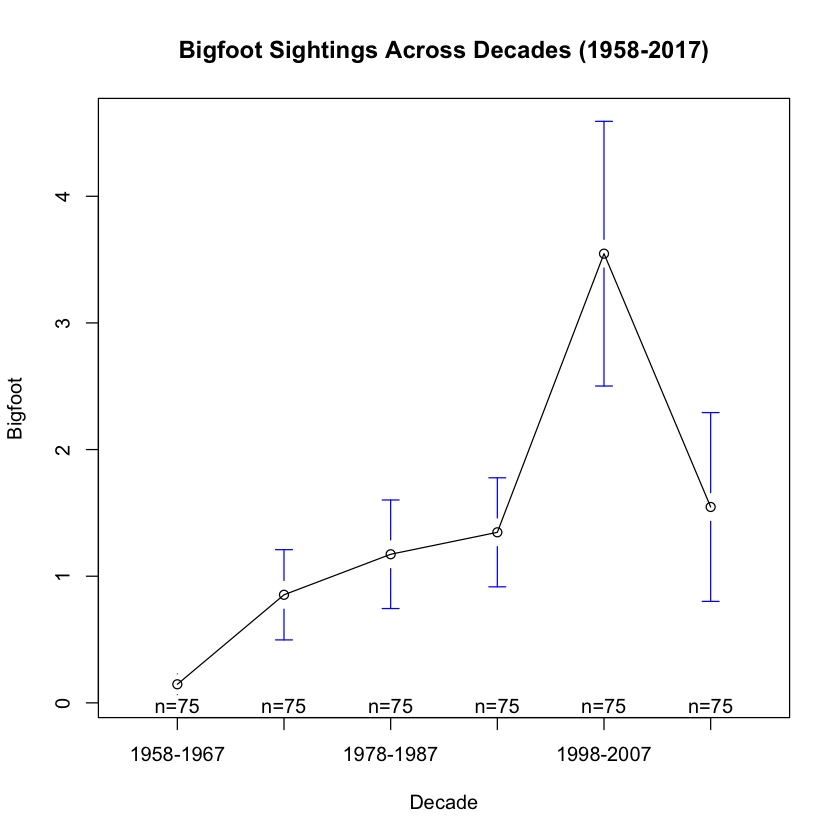

In [218]:
# plotmeans draw a 95% confidence interval around the means
plotmeans(Bigfoot ~ Decade, main="Bigfoot Sightings Across Decades (1958-2017)", data = bigfoot_subset)

In [28]:
# Writing bigfoot data to a csv file
write_csv(bigfoot, path = "bigfoot.csv")

In [29]:
bigfoot1 = bigfoot %>% mutate(log_pop = log(Population))
bigfoot1[bigfoot1 == -Inf] = 0
bigfoot1[bigfoot1 == 'NAN'] = 0

## OLS with stepwise AIC approach with interactions

First, I fit 10 different OLS models by performing 10-fold cross validation on the bigfoot dataset. I included seprate intercepts for each decade and state. Thus, the state-specific, and decade-specific model via dummy variables controls for differences across states and decades. This allows each estimate of the factor variable (state and decade) to absorb effects pertaining to each state, and decade, respectively. After inserting all the explanatory variables, I chose a stepwise regression approach (combination of forward and backward appraches) and chose the model with the lowest AIC. This automated process considers not only the combinations of linear terms but also their interactions. However, this approach yielded the best model as a very convoluted model best model comprising of all the variables and interactions with one another, most of which are statistically significant. However, the residuals vs fitted plot are heteroskedastic as the residuals are clustered on one side of the plot. Moreover, they are not normally distributed as they tail-off on both ends, implying they are skewed. The Appendix shows the model and the two diagonostic plots. 

In [30]:
# ordinary least squares on the train set with 10-fold CV using the caret package
# State-specific and decade-specific fixed effects model via dummy variables
# controls for differences across states and decades
# Each component of the factor variable state and decade has absorbed the effects particular to each state and decade

lm_fit = train(
  form = Bigfoot ~ (log_pop + Water + Developed + Forest + Agriculture + Wetlands +
            Snow.Barren + Grass.Shrub + factor(State) + factor(Decade))^2,
  data = bigfoot1,
  method = "lmStepAIC", # method for fit
  trControl = trainControl(method = "cv", number = 10)
)

summary(lm_fit)

Start:  AIC=544.29
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=542.29
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=540.31
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Wat


Step:  AIC=538.37
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Wat


Step:  AIC=536.46
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Wat


Step:  AIC=534.57
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Dev


Step:  AIC=532.68
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agricu


Step:  AIC=530.79
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agricu


Step:  AIC=528.82
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agricu


Step:  AIC=527.03
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agricu


Step:  AIC=525.11
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` +


Step:  AIC=523.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` +


Step:  AIC=521.69
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` +


Step:  AIC=519.99
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` +


Step:  AIC=518.57
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=516.59
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=515.14
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=513.89
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=512.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington


Step:  AIC=511.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=509.95
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=508.44
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=506.93
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto


Step:  AIC=505.37
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:factor(Decade)1968-1977`              1     0.254  989.87 501.94
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.419  990.03 502.01
- `Forest:factor(Decade)1968-1977`                   1     1.730  991.34 502.54
- `Agriculture:Wetlands`                             1     1.763  991.37 502.56
- `factor(Decade)1968-1977`                          1     3.623  993.23 503.32
- `factor(State)Washington`                          1     3.827  993.44 503.40
- `log_pop:factor(State)Washington`                  1     3.966  993.58 503.46
- `Developed:Forest`                                 1     4.615  994.23 503.72
<none>                                                            989.61 503.84
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.411  995.02 504.05
- `log_pop:factor(Decade)1978-1987`                  1     6.311  995.92 504.41
- `Developed:Agriculture`               


Step:  AIC=500.01
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washingto

                                                    Df Sum of Sq     RSS    AIC
- `Developed:Forest`                                 1     3.164  994.95 498.02
- `Forest:factor(Decade)1968-1977`                   1     4.725  996.51 498.65
<none>                                                            991.79 498.73
- `Developed:Agriculture`                            1     4.985  996.77 498.76
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.220  997.01 498.85
- Water                                              1     6.367  998.15 499.32
- `log_pop:factor(Decade)1978-1987`                  1     6.482  998.27 499.36
- `log_pop:factor(Decade)1968-1977`                  1     6.796  998.58 499.49
- `Snow.Barren:factor(Decade)1968-1977`              1     6.922  998.71 499.54
- `Forest:Grass.Shrub`                               1     7.494  999.28 499.78
- `factor(State)Washington`                          1     7.567  999.35 499.80
- `factor(Decade)1968-1977`             


Step:  AIC=496.76
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Dev

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1978-1987`                   1     4.339 1005.6 496.34
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.705 1006.0 496.49
- `Forest:Grass.Shrub`                               1     4.941 1006.2 496.58
<none>                                                           1001.3 496.59
- `factor(State)Washington`                          1     5.892 1007.2 496.96
- `log_pop:factor(State)Washington`                  1     6.159 1007.5 497.07
- `log_pop:factor(Decade)1978-1987`                  1     7.265 1008.5 497.52
- `factor(Decade)1968-1977`                          1     7.662 1009.0 497.67
- `factor(Decade)1978-1987`                          1     7.901 1009.2 497.77
- `log_pop:factor(Decade)1968-1977`                  1     9.660 1011.0 498.48
- `Snow.Barren:factor(Decade)1968-1977`              1    11.020 1012.3 499.02
- `Forest:factor(Decade)1988-1997`                  


Step:  AIC=496.14
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Dev

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1988-1997`                   1     3.610 1018.6 495.52
<none>                                                           1015.0 496.08
- `factor(State)Washington`                          1     6.410 1021.4 496.63
- `log_pop:factor(State)Washington`                  1     6.563 1021.5 496.69
- `factor(Decade)1988-1997`                          1     7.794 1022.8 497.18
- `factor(Decade)1968-1977`                          1     8.262 1023.2 497.36
- `factor(Decade)1978-1987`                          1     8.984 1023.9 497.65
- `Snow.Barren:factor(Decade)1968-1977`              1     9.934 1024.9 498.02
- `log_pop:factor(Decade)1988-1997`                  1     9.969 1024.9 498.04
- `log_pop:factor(Decade)1968-1977`                  1    10.413 1025.4 498.21
- `log_pop:factor(Decade)1978-1987`                  1    11.086 1026.0 498.48
- `Snow.Barren:factor(State)Washington`             

Start:  AIC=531.29
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=529.3
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decad


Step:  AIC=527.3
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decad


Step:  AIC=525.3
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decad


Step:  AIC=523.32
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=521.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=519.37
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=517.41
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=515.45
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=513.52
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=511.6
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` 


Step:  AIC=509.71
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `D


Step:  AIC=507.75
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Dev


Step:  AIC=505.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Dev


Step:  AIC=504.05
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Dev


Step:  AIC=502.23
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Dev


Step:  AIC=500.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + 


Step:  AIC=498.41
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + 


Step:  AIC=496.55
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + 


Step:  AIC=494.82
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + 


Step:  AIC=493.13
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + 


Step:  AIC=491.5
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `


Step:  AIC=489.9
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1988-1997`


Step:  AIC=488.44
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1988-1997` + `Developed:factor(Decade)1998-2007` +

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.262  953.56 486.66
- `Water:factor(Decade)1988-1997`                    1     3.522  953.82 486.77
- `Agriculture:Wetlands`                             1     3.960  954.26 486.96
<none>                                                            950.30 487.27
- `Developed:Forest`                                 1     4.721  955.02 487.28
- `Forest:factor(Decade)1978-1987`                   1     4.958  955.26 487.38
- `Grass.Shrub:factor(Decade)1968-1977`              1     4.980  955.28 487.39
- `log_pop:factor(Decade)1978-1987`                  1     5.393  955.69 487.57
- `factor(Decade)1978-1987`                          1     5.745  956.04 487.72
- `Agriculture:factor(Decade)1968-1977`              1     5.791  956.09 487.74
- `Agriculture:factor(Decade)1988-1997`              1     6.027  956.33 487.84
- Snow.Barren                           


Step:  AIC=485.76
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1988-1997` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-201

                                                    Df Sum of Sq     RSS    AIC
- `factor(Decade)1988-1997`                          1     0.974  959.44 483.16
- `Developed:factor(Decade)1988-1997`                1     1.046  959.52 483.19
- `Grass.Shrub:factor(Decade)1988-1997`              1     1.048  959.52 483.19
- `Grass.Shrub:factor(Decade)1968-1977`              1     3.914  962.38 484.40
- `Agriculture:Wetlands`                             1     4.278  962.75 484.56
- `Wetlands:factor(Decade)1968-1977`                 1     4.427  962.90 484.62
- `log_pop:factor(Decade)1978-1987`                  1     4.668  963.14 484.72
- `Forest:factor(Decade)1978-1987`                   1     4.723  963.19 484.74
<none>                                                            958.47 484.75
- `Developed:Forest`                                 1     4.952  963.42 484.84
- `factor(Decade)1978-1987`                          1     5.025  963.50 484.87
- `Agriculture:factor(Decade)1968-1977` 


Step:  AIC=481.2
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1988-1997` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agriculture

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:Wetlands`                             1     4.158  963.95 479.06
- `Wetlands:factor(Decade)1968-1977`                 1     4.579  964.37 479.24
<none>                                                            959.79 479.31
- `Developed:Forest`                                 1     4.988  964.78 479.41
- `log_pop:factor(Decade)1978-1987`                  1     5.045  964.84 479.44
- `Grass.Shrub:factor(Decade)1968-1977`              1     5.157  964.95 479.48
- `Agriculture:factor(Decade)1968-1977`              1     5.265  965.06 479.53
- `Forest:factor(Decade)1978-1987`                   1     5.573  965.36 479.66
- `factor(Decade)1978-1987`                          1     5.636  965.43 479.68
- Snow.Barren                                        1     5.886  965.68 479.79
- Water                                              1     7.256  967.05 480.36
- `Forest:Grass.Shrub`                  


Step:  AIC=478.11
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agriculture` + `Forest:Wetlands` + `Forest:Snow.Barren` + 
    `Forest:Gra

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:factor(Decade)1968-1977`                 1     4.620  972.91 476.82
<none>                                                            968.29 476.89
- `log_pop:factor(Decade)1978-1987`                  1     5.044  973.33 476.99
- `Agriculture:factor(Decade)1968-1977`              1     5.065  973.35 477.00
- `Grass.Shrub:factor(Decade)1968-1977`              1     5.121  973.41 477.03
- `Forest:factor(Decade)1978-1987`                   1     5.609  973.90 477.23
- `factor(Decade)1978-1987`                          1     5.764  974.05 477.30
- `Forest:Grass.Shrub`                               1     5.943  974.23 477.37
- Snow.Barren                                        1     6.456  974.74 477.58
- Water                                              1     8.303  976.59 478.35
- Wetlands                                           1     9.892  978.18 479.01
- `Snow.Barren:factor(Decade)1978-1987` 


Step:  AIC=475.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1978-1987` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agriculture` + `Forest:Wetlands` + `Forest:Snow.Barren` + 
    `Forest:Grass.Shrub` + `Forest:factor

                                                    Df Sum of Sq     RSS    AIC
- `factor(Decade)1978-1987`                          1     0.350  979.04 473.37
- `Agriculture:factor(Decade)1968-1977`              1     3.228  981.91 474.56
<none>                                                            978.69 475.22
- `Forest:Grass.Shrub`                               1     5.973  984.66 475.69
- `Forest:factor(Decade)1978-1987`                   1     6.414  985.10 475.87
- Snow.Barren                                        1     6.915  985.60 476.08
- Water                                              1     8.772  987.46 476.85
- Wetlands                                           1    10.417  989.10 477.52
- Developed                                          1    10.825  989.51 477.69
- Agriculture                                        1    10.852  989.54 477.70
- Forest                                             1    10.853  989.54 477.70
- Grass.Shrub                           


Step:  AIC=472.6
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agriculture` + `Forest:Wetlands` + `Forest:Snow.Barren` + 
    `Forest:Grass.Shrub` + `Forest:factor(Decade)1978-1987` + 
    `Forest:factor(Decade)1988-1997` + `Forest:f


Step:  AIC=535.38
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=533.38
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=531.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade


Step:  AIC=529.44
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=527.48
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=525.64
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=523.85
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=522.06
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=520.28
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=518.52
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=516.79
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=514.81
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=512.91
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=511.43
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=510.12
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:We


Step:  AIC=508.74
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Sn


Step:  AIC=507.85
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Sn


Step:  AIC=506.18
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Sn


Step:  AIC=505.43
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `


Step:  AIC=504.92
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `


Step:  AIC=504.75
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `


Step:  AIC=504.61
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `


Step:  AIC=503.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
 


Step:  AIC=501.73
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
 

                                                    Df Sum of Sq     RSS    AIC
- `Forest:factor(Decade)1968-1977`                   1     1.730  982.50 498.92
- `Snow.Barren:factor(Decade)1968-1977`              1     4.031  984.80 499.87
- `Developed:Forest`                                 1     4.358  985.13 500.00
- `factor(State)Washington:factor(Decade)1988-1997`  1     4.562  985.34 500.08
<none>                                                            980.77 500.20
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.556  986.33 500.49
- `log_pop:factor(Decade)1968-1977`                  1     6.664  987.44 500.95
- `factor(Decade)1968-1977`                          1     7.053  987.83 501.11
- `Developed:factor(Decade)1978-1987`                1     7.413  988.19 501.25
- `Agriculture:factor(Decade)1978-1987`              1     7.421  988.20 501.26
- `Grass.Shrub:factor(Decade)1978-1987`              1     7.424  988.20 501.26
- `Forest:factor(Decade)1978-1987`      


Step:  AIC=498.67
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(

                                                    Df Sum of Sq     RSS    AIC
- `Grass.Shrub:factor(Decade)1988-1997`              1     3.836  995.07 498.06
<none>                                                            991.23 498.50
- `Snow.Barren:factor(Decade)1968-1977`              1     5.452  996.68 498.72
- `Developed:Agriculture`                            1     6.921  998.15 499.32
- `factor(Decade)1968-1977`                          1     7.008  998.24 499.35
- `Developed:factor(Decade)1978-1987`                1     8.307  999.54 499.88
- `Agriculture:factor(Decade)1978-1987`              1     8.315  999.54 499.88
- `Grass.Shrub:factor(Decade)1978-1987`              1     8.318  999.55 499.88
- `Forest:factor(Decade)1978-1987`                   1     8.319  999.55 499.88
- `factor(Decade)1978-1987`                          1     8.339  999.57 499.89
- `Wetlands:factor(Decade)1978-1987`                 1     8.352  999.58 499.90
- `Forest:factor(Decade)1988-1997`      


Step:  AIC=497.92
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(

                                                    Df Sum of Sq    RSS    AIC
<none>                                                           1003.6 497.53
- `Developed:Agriculture`                            1     6.038 1009.6 497.96
- `factor(Decade)1968-1977`                          1     7.784 1011.4 498.66
- `Developed:factor(Decade)1978-1987`                1     8.554 1012.2 498.97
- `Grass.Shrub:factor(Decade)1978-1987`              1     8.564 1012.2 498.97
- `Agriculture:factor(Decade)1978-1987`              1     8.564 1012.2 498.97
- `Forest:factor(Decade)1978-1987`                   1     8.564 1012.2 498.97
- `factor(Decade)1978-1987`                          1     8.585 1012.2 498.98
- `Wetlands:factor(Decade)1978-1987`                 1     8.601 1012.2 498.98
- `Water:factor(Decade)1978-1987`                    1     8.678 1012.3 499.01
- `Snow.Barren:factor(Decade)1978-1987`              1     8.687 1012.3 499.02
- `log_pop:factor(Decade)1978-1987`                 


Step:  AIC=465.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=463.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=461.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=459.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=457.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=455.36
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=453.37
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=451.43
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 


Step:  AIC=449.54
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 


Step:  AIC=447.66
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 


Step:  AIC=445.66
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 


Step:  AIC=443.67
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=441.71
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=439.91
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=438.08
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=436.25
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=434.63
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=432.83
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=431.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=430.19
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=428.93
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:


Step:  AIC=427.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Develope


Step:  AIC=426.47
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Dev

                                                    Df Sum of Sq    RSS    AIC
- Snow.Barren                                        1     1.622 812.43 423.94
- `Water:factor(Decade)1968-1977`                    1     1.889 812.70 424.07
- `Agriculture:Grass.Shrub`                          1     2.075 812.89 424.16
- Water                                              1     2.468 813.28 424.36
- `Agriculture:factor(Decade)1988-1997`              1     3.188 814.00 424.72
- Wetlands                                           1     3.411 814.22 424.83
- Agriculture                                        1     3.519 814.33 424.88
- Forest                                             1     3.524 814.33 424.89
- Grass.Shrub                                        1     3.530 814.34 424.89
- Developed                                          1     3.537 814.35 424.89
<none>                                                           810.81 425.13
- `Developed:factor(Decade)1988-1997`               


Step:  AIC=422.86
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1968-1977` + 
    `Developed:fac

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:factor(Decade)1988-1997`              1     3.126 819.54 421.47
- `Developed:factor(Decade)1968-1977`                1     3.724 820.14 421.76
- `Forest:factor(Decade)1978-1987`                   1     4.031 820.45 421.92
<none>                                                           816.42 421.92
- `Agriculture:factor(Decade)1968-1977`              1     4.045 820.46 421.92
- `Developed:factor(Decade)1988-1997`                1     4.084 820.50 421.94
- `Grass.Shrub:factor(Decade)1968-1977`              1     4.518 820.94 422.16
- `Developed:Agriculture`                            1     4.785 821.20 422.29
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.823 821.24 422.31
- `Forest:factor(Decade)1968-1977`                   1     4.849 821.27 422.32
- `Forest:factor(Decade)1988-1997`                   1     5.659 822.08 422.72
- `Snow.Barren:factor(Decade)1968-1977`             


Step:  AIC=419.95
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1968-1977` + 
    `Developed:fac

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:factor(Decade)1968-1977`              1     0.520 823.09 417.22
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.982 823.56 417.45
- `Forest:factor(Decade)1968-1977`                   1     1.414 823.99 417.66
- `Grass.Shrub:factor(Decade)1988-1997`              1     3.222 825.80 418.55
- `Forest:factor(Decade)1978-1987`                   1     3.779 826.35 418.82
<none>                                                           822.57 418.96
- `Developed:Agriculture`                            1     4.453 827.03 419.15
- `Snow.Barren:factor(Decade)1968-1977`              1     5.017 827.59 419.43
- `factor(Decade)1968-1977`                          1     5.765 828.34 419.79
- `factor(Decade)1988-1997`                          1    10.497 833.07 422.10
- `log_pop:factor(Decade)1988-1997`                  1    10.859 833.43 422.28
- `Forest:factor(Decade)1988-1997`                  


Step:  AIC=415.46
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `Developed:fac

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1978-1987`                   1     2.740 827.40 413.33
- `Grass.Shrub:factor(Decade)1988-1997`              1     2.767 827.43 413.35
<none>                                                           824.66 413.99
- `Developed:Agriculture`                            1     4.547 829.21 414.22
- `Snow.Barren:factor(Decade)1968-1977`              1     7.547 832.21 415.68
- `Forest:factor(Decade)1988-1997`                   1     9.981 834.64 416.86
- `factor(Decade)1988-1997`                          1    10.010 834.67 416.88
- `log_pop:factor(Decade)1988-1997`                  1    11.148 835.81 417.43
- `factor(Decade)1968-1977`                          1    11.670 836.33 417.68
- `factor(Decade)1978-1987`                          1    12.997 837.66 418.32
- `log_pop:factor(Decade)1978-1987`                  1    13.010 837.67 418.33
- `Forest:Agriculture`                              


Step:  AIC=412.72
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `Developed:fac

                                                    Df Sum of Sq    RSS    AIC
<none>                                                           834.23 412.66
- `Forest:factor(Decade)1988-1997`                   1     4.834 839.06 413.00
- `Snow.Barren:factor(Decade)1968-1977`              1     6.286 840.51 413.70
- `factor(Decade)1988-1997`                          1     7.516 841.74 414.29
- `log_pop:factor(Decade)1988-1997`                  1     9.097 843.32 415.05
- `Developed:factor(State)Washington`                1     9.119 843.35 415.06
- `Forest:Agriculture`                               1    10.090 844.32 415.53
- `factor(Decade)1968-1977`                          1    12.049 846.28 416.47
- `Wetlands:Grass.Shrub`                             1    12.594 846.82 416.73
- `factor(Decade)1978-1987`                          1    12.823 847.05 416.84
- `log_pop:factor(Decade)1968-1977`                  1    14.210 848.44 417.50
- `Developed:Wetlands`                              

                                                    Df Sum of Sq     RSS    AIC
- `log_pop:factor(State)Washington`                  1     0.000  951.58 533.96
- `Developed:Grass.Shrub`                            1     0.009  951.59 533.97
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.075  951.65 534.00
- `Developed:Wetlands`                               1     0.095  951.67 534.01
- `Wetlands:Snow.Barren`                             1     0.165  951.74 534.04
- `factor(State)Washington`                          1     0.246  951.82 534.07
- `Wetlands:factor(Decade)1968-1977`                 1     0.415  951.99 534.14
- `Water:factor(Decade)1968-1977`                    1     0.437  952.01 534.15
- `Agriculture:factor(Decade)1968-1977`              1     0.439  952.02 534.15
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.441  952.02 534.15
- `Forest:factor(Decade)1968-1977`                   1     0.443  952.02 534.15
- `factor(Decade)1968-1977`             

                                                    Df Sum of Sq     RSS    AIC
- `Developed:Grass.Shrub`                            1     0.009  951.59 531.97
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.075  951.65 532.00
- `Developed:Wetlands`                               1     0.095  951.67 532.01
- `Wetlands:Snow.Barren`                             1     0.171  951.75 532.04
- `Wetlands:factor(Decade)1968-1977`                 1     0.415  951.99 532.14
- `Water:factor(Decade)1968-1977`                    1     0.437  952.02 532.15
- `Agriculture:factor(Decade)1968-1977`              1     0.439  952.02 532.15
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.441  952.02 532.15
- `Forest:factor(Decade)1968-1977`                   1     0.443  952.02 532.15
- `factor(Decade)1968-1977`                          1     0.445  952.02 532.15
- `Developed:factor(Decade)1968-1977`                1     0.446  952.02 532.15
- `Snow.Barren:factor(Decade)1968-1977` 

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.075  951.66 530.00
- `Developed:Wetlands`                               1     0.099  951.69 530.01
- `Wetlands:Snow.Barren`                             1     0.164  951.75 530.04
- `Wetlands:factor(Decade)1968-1977`                 1     0.417  952.00 530.15
- `Water:factor(Decade)1968-1977`                    1     0.440  952.03 530.16
- `Agriculture:factor(Decade)1968-1977`              1     0.442  952.03 530.16
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.444  952.03 530.16
- `Forest:factor(Decade)1968-1977`                   1     0.445  952.03 530.16
- `factor(Decade)1968-1977`                          1     0.448  952.03 530.16
- `Developed:factor(Decade)1968-1977`                1     0.449  952.04 530.16
- `Snow.Barren:factor(Decade)1968-1977`              1     0.460  952.05 530.16
- `Water:factor(State)Washington`       

                                                    Df Sum of Sq     RSS    AIC
- `Developed:Wetlands`                               1     0.101  951.76 528.04
- `Wetlands:Snow.Barren`                             1     0.171  951.83 528.07
- `Wetlands:factor(Decade)1968-1977`                 1     0.380  952.04 528.16
- `Water:factor(Decade)1968-1977`                    1     0.401  952.06 528.17
- `Agriculture:factor(Decade)1968-1977`              1     0.403  952.06 528.17
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.405  952.07 528.17
- `Forest:factor(Decade)1968-1977`                   1     0.407  952.07 528.17
- `factor(Decade)1968-1977`                          1     0.409  952.07 528.17
- `Developed:factor(Decade)1968-1977`                1     0.410  952.07 528.18
- `Snow.Barren:factor(Decade)1968-1977`              1     0.422  952.08 528.18
- `Water:factor(State)Washington`                    1     0.639  952.30 528.27
- `Water:factor(Decade)1978-1987`       

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:Snow.Barren`                             1     0.153  951.92 526.11
- `Wetlands:factor(Decade)1968-1977`                 1     0.376  952.14 526.20
- `Water:factor(Decade)1968-1977`                    1     0.397  952.16 526.21
- `Agriculture:factor(Decade)1968-1977`              1     0.399  952.16 526.21
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.401  952.16 526.21
- `Forest:factor(Decade)1968-1977`                   1     0.403  952.17 526.22
- `factor(Decade)1968-1977`                          1     0.405  952.17 526.22
- `Developed:factor(Decade)1968-1977`                1     0.406  952.17 526.22
- `Snow.Barren:factor(Decade)1968-1977`              1     0.418  952.18 526.22
- `Water:factor(State)Washington`                    1     0.613  952.38 526.30
- `Water:factor(Decade)1978-1987`                    1     0.829  952.59 526.40
- `Developed:factor(Decade)1978-1987`   

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:factor(Decade)1968-1977`                 1     0.380  952.30 524.27
- `Water:factor(Decade)1968-1977`                    1     0.401  952.32 524.28
- `Agriculture:factor(Decade)1968-1977`              1     0.403  952.32 524.28
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.405  952.32 524.28
- `Forest:factor(Decade)1968-1977`                   1     0.406  952.32 524.28
- `factor(Decade)1968-1977`                          1     0.409  952.33 524.28
- `Developed:factor(Decade)1968-1977`                1     0.409  952.33 524.28
- `Snow.Barren:factor(Decade)1968-1977`              1     0.421  952.34 524.29
- `Water:factor(State)Washington`                    1     0.522  952.44 524.33
- `Agriculture:Grass.Shrub`                          1     0.815  952.73 524.46
- `Water:factor(Decade)1978-1987`                    1     0.874  952.79 524.48
- `Developed:factor(Decade)1978-1987`   

                                                    Df Sum of Sq     RSS    AIC
- `Water:factor(State)Washington`                    1     0.521  952.82 522.49
- `Water:factor(Decade)1978-1987`                    1     0.529  952.82 522.50
- `Developed:factor(Decade)1978-1987`                1     0.529  952.83 522.50
- `Agriculture:factor(Decade)1978-1987`              1     0.531  952.83 522.50
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.533  952.83 522.50
- `Forest:factor(Decade)1978-1987`                   1     0.535  952.83 522.50
- `Wetlands:factor(Decade)1978-1987`                 1     0.538  952.83 522.50
- `factor(Decade)1978-1987`                          1     0.541  952.84 522.50
- `Snow.Barren:factor(Decade)1978-1987`              1     0.580  952.88 522.52
- `Snow.Barren:factor(Decade)1988-1997`              1     0.782  953.08 522.60
- `Wetlands:factor(Decade)1988-1997`                 1     0.784  953.08 522.60
- `Water:factor(Decade)1988-1997`       

                                                    Df Sum of Sq     RSS    AIC
- `Water:factor(Decade)1978-1987`                    1     0.534  953.35 520.72
- `Developed:factor(Decade)1978-1987`                1     0.535  953.35 520.72
- `Agriculture:factor(Decade)1978-1987`              1     0.536  953.35 520.72
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.538  953.35 520.72
- `Forest:factor(Decade)1978-1987`                   1     0.540  953.36 520.72
- `Wetlands:factor(Decade)1978-1987`                 1     0.543  953.36 520.72
- `factor(Decade)1978-1987`                          1     0.546  953.36 520.72
- `Snow.Barren:factor(Decade)1978-1987`              1     0.586  953.40 520.74
- `Agriculture:Grass.Shrub`                          1     0.759  953.58 520.81
- `Snow.Barren:factor(Decade)1988-1997`              1     0.856  953.67 520.86
- `Wetlands:factor(Decade)1988-1997`                 1     0.858  953.67 520.86
- `Water:factor(Decade)1988-1997`       

                                                    Df Sum of Sq     RSS    AIC
- `Developed:factor(Decade)1978-1987`                1     0.003  953.35 518.72
- `Agriculture:factor(Decade)1978-1987`              1     0.022  953.37 518.73
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.097  953.45 518.76
- `Forest:factor(Decade)1978-1987`                   1     0.169  953.52 518.79
- `Wetlands:factor(Decade)1978-1987`                 1     0.180  953.53 518.79
- `Snow.Barren:factor(Decade)1988-1997`              1     0.514  953.86 518.94
- `Wetlands:factor(Decade)1988-1997`                 1     0.515  953.87 518.94
- `Water:factor(Decade)1988-1997`                    1     0.539  953.89 518.95
- `Agriculture:factor(Decade)1988-1997`              1     0.542  953.89 518.95
- `Grass.Shrub:factor(Decade)1988-1997`              1     0.548  953.90 518.95
- `Forest:factor(Decade)1988-1997`                   1     0.550  953.90 518.95
- `Developed:factor(Decade)1988-1997`   

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:factor(Decade)1978-1987`              1     0.062  953.42 516.75
- `Wetlands:factor(Decade)1978-1987`                 1     0.226  953.58 516.82
- `Snow.Barren:factor(Decade)1988-1997`              1     0.517  953.87 516.94
- `Wetlands:factor(Decade)1988-1997`                 1     0.518  953.87 516.94
- `Water:factor(Decade)1988-1997`                    1     0.542  953.90 516.95
- `Agriculture:factor(Decade)1988-1997`              1     0.544  953.90 516.95
- `Grass.Shrub:factor(Decade)1988-1997`              1     0.551  953.90 516.95
- `Forest:factor(Decade)1988-1997`                   1     0.552  953.91 516.95
- `Developed:factor(Decade)1988-1997`                1     0.554  953.91 516.96
- `factor(Decade)1988-1997`                          1     0.556  953.91 516.96
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.584  953.94 516.97
- `Agriculture:Grass.Shrub`             

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:factor(Decade)1978-1987`                 1     0.169  953.58 514.82
- `Snow.Barren:factor(Decade)1988-1997`              1     0.519  953.93 514.97
- `Wetlands:factor(Decade)1988-1997`                 1     0.520  953.93 514.97
- `Water:factor(Decade)1988-1997`                    1     0.545  953.96 514.98
- `Agriculture:factor(Decade)1988-1997`              1     0.547  953.96 514.98
- `Grass.Shrub:factor(Decade)1988-1997`              1     0.554  953.97 514.98
- `Forest:factor(Decade)1988-1997`                   1     0.555  953.97 514.98
- `Developed:factor(Decade)1988-1997`                1     0.557  953.97 514.98
- `factor(Decade)1988-1997`                          1     0.559  953.97 514.98
- `Agriculture:Grass.Shrub`                          1     0.776  954.19 515.08
- `Forest:factor(State)Washington`                   1     0.932  954.35 515.14
- `factor(State)Washington:factor(Decade

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:factor(Decade)1988-1997`                 1     0.529  954.11 513.04
- `Snow.Barren:factor(Decade)1988-1997`              1     0.531  954.11 513.04
- `Water:factor(Decade)1988-1997`                    1     0.557  954.14 513.05
- `Agriculture:factor(Decade)1988-1997`              1     0.559  954.14 513.06
- `Grass.Shrub:factor(Decade)1988-1997`              1     0.566  954.15 513.06
- `Forest:factor(Decade)1988-1997`                   1     0.568  954.15 513.06
- `Developed:factor(Decade)1988-1997`                1     0.570  954.15 513.06
- `factor(Decade)1988-1997`                          1     0.571  954.16 513.06
- `Agriculture:Grass.Shrub`                          1     0.773  954.36 513.15
- `Forest:factor(State)Washington`                   1     0.890  954.47 513.20
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.463  955.05 513.44
- `factor(State)Washington:factor(Decade

                                                    Df Sum of Sq     RSS    AIC
- `Snow.Barren:factor(Decade)1988-1997`              1     0.007  954.12 511.05
- `Agriculture:Grass.Shrub`                          1     0.785  954.90 511.38
- `Forest:factor(State)Washington`                   1     0.921  955.03 511.43
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.439  955.55 511.65
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.481  955.59 511.67
- `Agriculture:factor(State)Washington`              1     1.533  955.65 511.69
- `factor(State)Washington`                          1     2.248  956.36 512.00
- `Water:factor(Decade)1988-1997`                    1     2.377  956.49 512.05
- `Water:factor(Decade)1968-1977`                    1     2.893  957.01 512.27
- `Forest:Grass.Shrub`                               1     3.740  957.85 512.63
- `Developed:Forest`                                 1     3.814  957.93 512.66
- `log_pop:factor(Decade)1968-1977`     

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:Grass.Shrub`                          1     0.787  954.91 509.38
- `Forest:factor(State)Washington`                   1     0.925  955.04 509.44
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.449  955.57 509.66
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.506  955.63 509.68
- `Agriculture:factor(State)Washington`              1     1.534  955.65 509.70
- `factor(State)Washington`                          1     2.269  956.39 510.01
- `Water:factor(Decade)1988-1997`                    1     2.541  956.66 510.12
- `Water:factor(Decade)1968-1977`                    1     2.897  957.02 510.27
- `Forest:Grass.Shrub`                               1     3.758  957.88 510.64
- `Developed:Forest`                                 1     3.811  957.93 510.66
- `Developed:Agriculture`                            1     4.687  958.81 511.03
- `log_pop:factor(Decade)1968-1977`     

                                                    Df Sum of Sq     RSS    AIC
- `Forest:factor(State)Washington`                   1     0.589  955.50 507.63
- `Agriculture:factor(State)Washington`              1     1.044  955.95 507.82
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.395  956.30 507.97
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.453  956.36 507.99
- `factor(State)Washington`                          1     1.696  956.60 508.10
- `Water:factor(Decade)1988-1997`                    1     2.591  957.50 508.48
- `Water:factor(Decade)1968-1977`                    1     2.867  957.77 508.59
- `log_pop:factor(Decade)1968-1977`                  1     4.635  959.54 509.34
<none>                                                            954.91 509.38
- `Developed:Forest`                                 1     4.846  959.75 509.43
- `Developed:Agriculture`                            1     5.013  959.92 509.50
- `Forest:factor(Decade)1978-1987`      

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:factor(State)Washington`              1     0.536  956.03 505.86
- `factor(State)Washington`                          1     1.115  956.61 506.10
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.457  956.95 506.25
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.462  956.96 506.25
- `Water:factor(Decade)1988-1997`                    1     2.603  958.10 506.73
- `Water:factor(Decade)1968-1977`                    1     2.797  958.29 506.81
- `Developed:Forest`                                 1     4.272  959.77 507.44
- `Developed:Agriculture`                            1     4.482  959.98 507.52
- `log_pop:factor(Decade)1968-1977`                  1     4.612  960.11 507.58
<none>                                                            955.50 507.63
- `Forest:factor(Decade)1978-1987`                   1     5.710  961.21 508.04
- `Agriculture:factor(Decade)1968-1977` 

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington`                          1     0.626  956.66 504.12
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.408  957.44 504.45
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.455  957.49 504.47
- `Water:factor(Decade)1988-1997`                    1     2.590  958.62 504.95
- `Water:factor(Decade)1968-1977`                    1     2.878  958.91 505.07
- `Developed:Forest`                                 1     3.825  959.86 505.47
- `Developed:Agriculture`                            1     3.998  960.03 505.55
- `log_pop:factor(Decade)1968-1977`                  1     4.540  960.57 505.77
<none>                                                            956.03 505.86
- `Forest:factor(Decade)1978-1987`                   1     5.658  961.69 506.25
- `Agriculture:Wetlands`                             1     6.067  962.10 506.42
- `Agriculture:factor(Decade)1968-1977` 

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.021  957.68 502.55
- `Grass.Shrub:factor(Decade)1978-1987`              1     1.289  957.95 502.67
- `Water:factor(Decade)1988-1997`                    1     2.484  959.14 503.17
- `Water:factor(Decade)1968-1977`                    1     2.931  959.59 503.36
- `Developed:Forest`                                 1     3.870  960.53 503.76
- `Developed:Agriculture`                            1     4.232  960.89 503.91
- `log_pop:factor(Decade)1968-1977`                  1     4.574  961.23 504.05
<none>                                                            956.66 504.12
- `Forest:factor(Decade)1978-1987`                   1     5.438  962.10 504.42
- `factor(State)Washington:factor(Decade)1988-1997`  1     5.812  962.47 504.57
- `Agriculture:Wetlands`                             1     5.833  962.49 504.58
- `Agriculture:factor(Decade)1968-1977` 

                                                    Df Sum of Sq     RSS    AIC
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.810  958.49 500.90
- `Water:factor(Decade)1988-1997`                    1     2.526  960.20 501.62
- `Water:factor(Decade)1968-1977`                    1     3.043  960.72 501.84
- `Developed:Forest`                                 1     3.793  961.47 502.15
- `Developed:Agriculture`                            1     4.135  961.81 502.30
- `log_pop:factor(Decade)1968-1977`                  1     4.664  962.34 502.52
- `Forest:factor(Decade)1978-1987`                   1     4.677  962.35 502.53
<none>                                                            957.68 502.55
- `factor(State)Washington:factor(Decade)1988-1997`  1     4.980  962.66 502.65
- `Agriculture:Wetlands`                             1     5.782  963.46 502.99
- `Agriculture:factor(Decade)1968-1977`              1     6.277  963.95 503.20
- `Agriculture:factor(Decade)1988-1997` 

                                                    Df Sum of Sq     RSS    AIC
- `Water:factor(Decade)1988-1997`                    1     2.471  960.96 499.94
- `Water:factor(Decade)1968-1977`                    1     3.025  961.51 500.17
- `Developed:Forest`                                 1     3.800  962.29 500.50
- `log_pop:factor(Decade)1968-1977`                  1     4.071  962.56 500.61
- `Developed:Agriculture`                            1     4.114  962.60 500.63
- `Forest:factor(Decade)1978-1987`                   1     4.644  963.13 500.85
<none>                                                            958.49 500.90
- `factor(State)Washington:factor(Decade)1988-1997`  1     4.996  963.48 501.00
- `Agriculture:Wetlands`                             1     5.880  964.37 501.37
- `Agriculture:factor(Decade)1968-1977`              1     6.249  964.74 501.53
- `Agriculture:factor(Decade)1988-1997`              1     6.415  964.90 501.60
- `Developed:factor(Decade)1968-1977`   

                                                    Df Sum of Sq     RSS    AIC
- `Water:factor(Decade)1968-1977`                    1     1.742  962.70 498.67
- `Developed:Forest`                                 1     3.889  964.85 499.57
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.921  964.88 499.59
- `Agriculture:factor(Decade)1988-1997`              1     4.004  964.96 499.62
- `Developed:Agriculture`                            1     4.211  965.17 499.71
- `log_pop:factor(Decade)1968-1977`                  1     4.329  965.29 499.76
- `Forest:factor(Decade)1978-1987`                   1     4.358  965.32 499.77
<none>                                                            960.96 499.94
- `Developed:factor(Decade)1988-1997`                1     4.784  965.74 499.95
- `Agriculture:factor(Decade)1968-1977`              1     4.993  965.95 500.04
- `Grass.Shrub:factor(Decade)1968-1977`              1     5.513  966.47 500.25
- `Developed:factor(Decade)1968-1977`   

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:factor(Decade)1968-1977`              1     3.467  966.17 498.13
- `Developed:Forest`                                 1     3.774  966.48 498.26
- `Developed:factor(Decade)1968-1977`                1     3.926  966.63 498.32
- `factor(State)Washington:factor(Decade)1988-1997`  1     4.023  966.72 498.36
- `Agriculture:factor(Decade)1988-1997`              1     4.043  966.74 498.37
- `Grass.Shrub:factor(Decade)1968-1977`              1     4.111  966.81 498.40
- `Developed:Agriculture`                            1     4.153  966.85 498.41
- `Forest:factor(Decade)1978-1987`                   1     4.376  967.08 498.51
<none>                                                            962.70 498.67
- `Forest:factor(Decade)1968-1977`                   1     4.773  967.47 498.67
- `Developed:factor(Decade)1988-1997`                1     4.809  967.51 498.69
- `log_pop:factor(Decade)1968-1977`     

                                                    Df Sum of Sq     RSS    AIC
- `Developed:factor(Decade)1968-1977`                1     0.477  966.65 496.33
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.927  967.10 496.52
- `Agriculture:factor(Decade)1988-1997`              1     2.312  968.48 497.10
- `Developed:factor(Decade)1988-1997`                1     3.102  969.27 497.43
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.673  969.84 497.66
- `Developed:Forest`                                 1     3.814  969.98 497.72
- `Snow.Barren:factor(Decade)1968-1977`              1     3.899  970.07 497.76
- `Forest:factor(Decade)1968-1977`                   1     3.911  970.08 497.76
- `Forest:factor(Decade)1978-1987`                   1     4.243  970.41 497.90
- `Developed:Agriculture`                            1     4.286  970.45 497.92
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.616  970.78 498.06
<none>                                  


Step:  AIC=494.54
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1988-1997` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
- `Developed:factor(Decade)1988-1997`                1     0.492  969.95 491.71
- `Forest:factor(Decade)1968-1977`                   1     3.045  972.50 492.77
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.249  972.71 492.86
- `Forest:factor(Decade)1978-1987`                   1     3.826  973.28 493.10
- `Developed:Forest`                                 1     3.939  973.40 493.15
- `Developed:Agriculture`                            1     4.394  973.85 493.34
<none>                                                            969.46 493.50
- `Snow.Barren:factor(Decade)1968-1977`              1     5.431  974.89 493.77
- `Agriculture:Wetlands`                             1     5.909  975.37 493.97
- `Grass.Shrub:factor(Decade)1988-1997`              1     6.328  975.79 494.14
- Snow.Barren                                        1     6.426  975.89 494.18
- `Forest:Grass.Shrub`                  


Step:  AIC=490.96
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.905  978.51 489.27
- `Developed:Forest`                                 1     4.270  978.87 489.42
- `Developed:Agriculture`                            1     4.287  978.89 489.43
<none>                                                            974.60 489.65
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.960  980.56 490.12
- `Agriculture:Wetlands`                             1     6.440  981.04 490.31
- Snow.Barren                                        1     6.583  981.18 490.37
- `Forest:Grass.Shrub`                               1     6.956  981.56 490.53
- `Forest:factor(Decade)1988-1997`                   1     7.911  982.51 490.92
- Water                                              1     8.222  982.82 491.05
- `factor(Decade)1968-1977`                          1     8.331  982.93 491.09
- `Snow.Barren:factor(Decade)1968-1977` 


Step:  AIC=488.85
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)200

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:Wetlands`                             1     2.684  985.38 486.10
- `Grass.Shrub:factor(Decade)1988-1997`              1     3.788  986.48 486.55
- `Forest:Grass.Shrub`                               1     4.846  987.54 486.99
<none>                                                            982.70 487.00
- `Forest:factor(Decade)1988-1997`                   1     5.504  988.20 487.26
- `Forest:Agriculture`                               1     7.249  989.94 487.97
- `Snow.Barren:factor(Decade)1968-1977`              1     7.303  990.00 488.00
- Snow.Barren                                        1     7.355  990.05 488.02
- `factor(Decade)1968-1977`                          1     8.080  990.78 488.31
- `Forest:Wetlands`                                  1     8.832  991.53 488.62
- Water                                              1     9.469  992.16 488.88
- `log_pop:factor(Decade)1968-1977`     


Step:  AIC=485.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agri

                                                    Df Sum of Sq     RSS    AIC
<none>                                                            991.30 484.53
- `Snow.Barren:factor(Decade)1968-1977`              1     6.046  997.35 484.99
- `Forest:Grass.Shrub`                               1     6.215  997.52 485.06
- Snow.Barren                                        1     7.711  999.01 485.67
- `factor(Decade)1988-1997`                          1     7.840  999.14 485.72
- `Forest:Wetlands`                                  1     7.996  999.30 485.78
- `factor(Decade)1968-1977`                          1     8.137  999.44 485.84
- Water                                              1     9.762 1001.06 486.50
- `log_pop:factor(Decade)1968-1977`                  1    10.220 1001.52 486.68
- `Forest:Agriculture`                               1    11.084 1002.39 487.03
- `factor(Decade)1978-1987`                          1    11.314 1002.62 487.13
- Wetlands                              

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:Wetlands`                             1     0.004 837.47 482.23
- `Water:factor(Decade)2008-2017`                    1     0.048 837.51 482.25
- `Agriculture:factor(Decade)2008-2017`              1     0.050 837.52 482.25
- `Developed:factor(Decade)2008-2017`                1     0.050 837.52 482.25
- `Forest:factor(Decade)2008-2017`                   1     0.051 837.52 482.25
- `Grass.Shrub:factor(Decade)2008-2017`              1     0.051 837.52 482.25
- `Wetlands:factor(Decade)2008-2017`                 1     0.052 837.52 482.25
- `factor(Decade)2008-2017`                          1     0.053 837.52 482.26
- `Water:factor(Decade)1978-1987`                    1     0.067 837.53 482.26
- `Developed:factor(Decade)1978-1987`                1     0.070 837.54 482.26
- `Agriculture:factor(Decade)1978-1987`              1     0.070 837.54 482.26
- `Wetlands:factor(Decade)1978-1987`                

                                                    Df Sum of Sq    RSS    AIC
- `Water:factor(Decade)2008-2017`                    1     0.046 837.52 480.25
- `Agriculture:factor(Decade)2008-2017`              1     0.049 837.52 480.25
- `Developed:factor(Decade)2008-2017`                1     0.049 837.52 480.25
- `Forest:factor(Decade)2008-2017`                   1     0.049 837.52 480.26
- `Grass.Shrub:factor(Decade)2008-2017`              1     0.050 837.52 480.26
- `Wetlands:factor(Decade)2008-2017`                 1     0.050 837.52 480.26
- `factor(Decade)2008-2017`                          1     0.052 837.52 480.26
- `Water:factor(Decade)1978-1987`                    1     0.066 837.53 480.26
- `Developed:factor(Decade)1978-1987`                1     0.069 837.54 480.26
- `Agriculture:factor(Decade)1978-1987`              1     0.069 837.54 480.26
- `Wetlands:factor(Decade)1978-1987`                 1     0.069 837.54 480.26
- `Grass.Shrub:factor(Decade)1978-1987`             

                                                    Df Sum of Sq    RSS    AIC
- `Water:factor(Decade)1978-1987`                    1     0.042 837.56 478.27
- `Developed:factor(Decade)1978-1987`                1     0.044 837.56 478.28
- `Agriculture:factor(Decade)1978-1987`              1     0.044 837.56 478.28
- `Wetlands:factor(Decade)1978-1987`                 1     0.045 837.56 478.28
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.045 837.56 478.28
- `Forest:factor(Decade)1978-1987`                   1     0.045 837.56 478.28
- `factor(Decade)1978-1987`                          1     0.047 837.56 478.28
- `Snow.Barren:factor(Decade)1978-1987`              1     0.053 837.57 478.28
- `Forest:factor(State)Washington`                   1     0.135 837.65 478.32
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.153 837.67 478.33
- `Wetlands:factor(Decade)1968-1977`                 1     0.435 837.95 478.46
- `Water:factor(State)Washington`                   

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(State)Washington`                   1     0.135 837.69 476.34
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.143 837.70 476.34
- `Wetlands:factor(Decade)1978-1987`                 1     0.305 837.86 476.42
- `Developed:factor(Decade)1978-1987`                1     0.318 837.87 476.43
- `Wetlands:factor(Decade)1968-1977`                 1     0.403 837.96 476.47
- `Water:factor(Decade)1968-1977`                    1     0.428 837.98 476.48
- `Agriculture:factor(Decade)1968-1977`              1     0.429 837.99 476.48
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.431 837.99 476.48
- `Forest:factor(Decade)1968-1977`                   1     0.433 837.99 476.48
- `Developed:factor(Decade)1968-1977`                1     0.434 837.99 476.48
- `factor(Decade)1968-1977`                          1     0.437 837.99 476.49
- `Snow.Barren:factor(Decade)1968-1977`             

                                                    Df Sum of Sq    RSS    AIC
- `factor(State)Washington:factor(Decade)1968-1977`  1     0.139 837.83 474.41
- `Developed:factor(Decade)1978-1987`                1     0.293 837.98 474.48
- `Wetlands:factor(Decade)1978-1987`                 1     0.295 837.99 474.48
- `Wetlands:factor(Decade)1968-1977`                 1     0.393 838.08 474.53
- `Water:factor(Decade)1968-1977`                    1     0.417 838.11 474.54
- `Agriculture:factor(Decade)1968-1977`              1     0.419 838.11 474.54
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.421 838.11 474.54
- `Forest:factor(Decade)1968-1977`                   1     0.423 838.11 474.54
- `Developed:factor(Decade)1968-1977`                1     0.423 838.11 474.54
- `factor(Decade)1968-1977`                          1     0.426 838.12 474.55
- `Agriculture:factor(State)Washington`              1     0.430 838.12 474.55
- `Snow.Barren:factor(Decade)1968-1977`             

                                                    Df Sum of Sq    RSS    AIC
- `Developed:factor(Decade)1978-1987`                1     0.306 838.14 472.55
- `Wetlands:factor(Decade)1978-1987`                 1     0.308 838.14 472.55
- `Wetlands:factor(Decade)1968-1977`                 1     0.341 838.17 472.57
- `Water:factor(Decade)1968-1977`                    1     0.363 838.19 472.58
- `Agriculture:factor(Decade)1968-1977`              1     0.365 838.20 472.58
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.367 838.20 472.58
- `Forest:factor(Decade)1968-1977`                   1     0.369 838.20 472.58
- `Developed:factor(Decade)1968-1977`                1     0.369 838.20 472.58
- `factor(Decade)1968-1977`                          1     0.372 838.20 472.59
- `Snow.Barren:factor(Decade)1968-1977`              1     0.382 838.21 472.59
- `Agriculture:factor(State)Washington`              1     0.462 838.29 472.63
- `Agriculture:factor(Decade)1978-1987`             

                                                    Df Sum of Sq    RSS    AIC
- `Wetlands:factor(Decade)1978-1987`                 1     0.088 838.22 470.60
- `Agriculture:factor(Decade)1978-1987`              1     0.232 838.37 470.67
- `Wetlands:factor(Decade)1968-1977`                 1     0.329 838.47 470.71
- `Agriculture:factor(Decade)1968-1977`              1     0.353 838.49 470.72
- `Water:factor(Decade)1968-1977`                    1     0.354 838.49 470.72
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.354 838.49 470.72
- `Developed:factor(Decade)1968-1977`                1     0.356 838.49 470.73
- `Forest:factor(Decade)1968-1977`                   1     0.356 838.49 470.73
- `factor(Decade)1968-1977`                          1     0.360 838.50 470.73
- `Snow.Barren:factor(Decade)1968-1977`              1     0.370 838.51 470.73
- `Developed:factor(Decade)2008-2017`                1     0.414 838.55 470.75
- `Agriculture:factor(State)Washington`             

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:factor(Decade)1978-1987`              1     0.144 838.37 468.67
- `Wetlands:factor(Decade)1968-1977`                 1     0.329 838.55 468.76
- `Agriculture:factor(Decade)1968-1977`              1     0.354 838.58 468.77
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.356 838.58 468.77
- `Water:factor(Decade)1968-1977`                    1     0.356 838.58 468.77
- `Developed:factor(Decade)1968-1977`                1     0.358 838.58 468.77
- `Forest:factor(Decade)1968-1977`                   1     0.358 838.58 468.77
- `factor(Decade)1968-1977`                          1     0.361 838.58 468.77
- `Snow.Barren:factor(Decade)1968-1977`              1     0.371 838.59 468.78
- `Developed:factor(Decade)2008-2017`                1     0.406 838.63 468.79
- `Agriculture:factor(State)Washington`              1     0.425 838.65 468.80
- `Water:factor(State)Washington`                   

                                                    Df Sum of Sq    RSS    AIC
- `Wetlands:factor(Decade)1968-1977`                 1     0.335 838.70 466.83
- `Agriculture:factor(Decade)1968-1977`              1     0.360 838.73 466.84
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.362 838.73 466.84
- `Water:factor(Decade)1968-1977`                    1     0.363 838.73 466.84
- `Forest:factor(Decade)1968-1977`                   1     0.364 838.73 466.84
- `Developed:factor(Decade)1968-1977`                1     0.365 838.73 466.84
- `factor(Decade)1968-1977`                          1     0.367 838.73 466.84
- `Snow.Barren:factor(Decade)1968-1977`              1     0.377 838.75 466.85
- `Developed:factor(Decade)2008-2017`                1     0.427 838.79 466.87
- `Agriculture:factor(State)Washington`              1     0.430 838.80 466.87
- `Water:factor(State)Washington`                    1     0.577 838.95 466.94
- `Snow.Barren:factor(Decade)1988-1997`             

                                                    Df Sum of Sq    RSS    AIC
- `Snow.Barren:factor(Decade)1988-1997`              1     0.396 839.10 465.02
- `Wetlands:factor(Decade)1988-1997`                 1     0.410 839.11 465.03
- `Water:factor(Decade)1988-1997`                    1     0.425 839.13 465.03
- `Agriculture:factor(Decade)1988-1997`              1     0.426 839.13 465.03
- `Developed:factor(Decade)1988-1997`                1     0.431 839.13 465.04
- `Grass.Shrub:factor(Decade)1988-1997`              1     0.431 839.13 465.04
- `Forest:factor(Decade)1988-1997`                   1     0.433 839.14 465.04
- `Developed:factor(Decade)2008-2017`                1     0.437 839.14 465.04
- `factor(Decade)1988-1997`                          1     0.438 839.14 465.04
- `Agriculture:factor(State)Washington`              1     0.439 839.14 465.04
- `Water:factor(State)Washington`                    1     0.589 839.29 465.11
- `Agriculture:factor(Decade)2008-2017`             

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:factor(State)Washington`              1     0.444 839.54 463.23
- `Developed:factor(Decade)2008-2017`                1     0.493 839.59 463.26
- `Wetlands:factor(Decade)1988-1997`                 1     0.507 839.61 463.26
- `Water:factor(State)Washington`                    1     0.571 839.67 463.29
- `Agriculture:factor(Decade)2008-2017`              1     0.709 839.81 463.36
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.759 839.86 463.39
- `Wetlands:Snow.Barren`                             1     0.772 839.87 463.39
- Snow.Barren                                        1     0.879 839.98 463.44
- `Agriculture:Grass.Shrub`                          1     1.048 840.15 463.52
- `Wetlands:factor(Decade)2008-2017`                 1     1.226 840.32 463.61
- `Forest:Wetlands`                                  1     1.268 840.37 463.63
- `Forest:Grass.Shrub`                              

                                                    Df Sum of Sq    RSS    AIC
- `Water:factor(State)Washington`                    1     0.361 839.90 461.41
- `Developed:factor(Decade)2008-2017`                1     0.432 839.97 461.44
- `Wetlands:factor(Decade)1988-1997`                 1     0.536 840.08 461.49
- `Agriculture:factor(Decade)2008-2017`              1     0.653 840.20 461.55
- `Wetlands:Snow.Barren`                             1     0.745 840.29 461.59
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.793 840.34 461.62
- `Forest:Wetlands`                                  1     0.910 840.45 461.67
- `Agriculture:Grass.Shrub`                          1     0.931 840.47 461.68
- Snow.Barren                                        1     1.067 840.61 461.75
- `Wetlands:factor(Decade)2008-2017`                 1     1.189 840.73 461.81
- `Forest:Grass.Shrub`                               1     1.225 840.77 461.82
- `Forest:factor(Decade)2008-2017`                  

                                                    Df Sum of Sq    RSS    AIC
- `Developed:factor(Decade)2008-2017`                1     0.453 840.36 459.63
- `Wetlands:factor(Decade)1988-1997`                 1     0.569 840.47 459.68
- `Agriculture:factor(Decade)2008-2017`              1     0.683 840.59 459.74
- `Wetlands:Snow.Barren`                             1     0.691 840.60 459.74
- `Forest:Wetlands`                                  1     0.716 840.62 459.75
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.781 840.68 459.78
- Snow.Barren                                        1     1.019 840.92 459.90
- `Agriculture:Grass.Shrub`                          1     1.112 841.02 459.94
- `Forest:Grass.Shrub`                               1     1.112 841.02 459.94
- `Wetlands:factor(Decade)2008-2017`                 1     1.154 841.06 459.96
- Water                                              1     1.453 841.36 460.11
- `Forest:factor(Decade)2008-2017`                  

                                                    Df Sum of Sq    RSS    AIC
- `Agriculture:factor(Decade)2008-2017`              1     0.299 840.66 457.77
- `Wetlands:factor(Decade)1988-1997`                 1     0.582 840.94 457.91
- `Forest:Wetlands`                                  1     0.678 841.03 457.95
- `Wetlands:factor(Decade)2008-2017`                 1     0.706 841.06 457.97
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.825 841.18 458.02
- `Wetlands:Snow.Barren`                             1     0.884 841.24 458.05
- `Agriculture:Grass.Shrub`                          1     1.055 841.41 458.13
- `Forest:Grass.Shrub`                               1     1.107 841.46 458.16
- Snow.Barren                                        1     1.325 841.68 458.26
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.692 842.05 458.44
- Water                                              1     1.849 842.21 458.52
- `factor(State)Washington:factor(Decade)1988-1997` 

                                                    Df Sum of Sq    RSS    AIC
- `Wetlands:factor(Decade)2008-2017`                 1     0.408 841.06 455.97
- `Wetlands:factor(Decade)1988-1997`                 1     0.550 841.21 456.03
- `Forest:Wetlands`                                  1     0.644 841.30 456.08
- `Wetlands:Snow.Barren`                             1     0.780 841.44 456.15
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.798 841.45 456.15
- `Forest:Grass.Shrub`                               1     1.020 841.68 456.26
- `Agriculture:Grass.Shrub`                          1     1.218 841.87 456.36
- Snow.Barren                                        1     1.261 841.92 456.38
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.702 842.36 456.59
- Water                                              1     1.770 842.43 456.62
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.861 842.52 456.67
- `Water:factor(Decade)1988-1997`                   

                                                    Df Sum of Sq    RSS    AIC
- `Wetlands:factor(Decade)1988-1997`                 1     0.423 841.49 454.17
- `Forest:Wetlands`                                  1     0.614 841.68 454.26
- `Wetlands:Snow.Barren`                             1     0.793 841.86 454.35
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.815 841.88 454.36
- `Forest:Grass.Shrub`                               1     1.088 842.15 454.49
- `Agriculture:Grass.Shrub`                          1     1.193 842.26 454.54
- Snow.Barren                                        1     1.285 842.35 454.58
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.666 842.73 454.77
- Water                                              1     1.795 842.86 454.83
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.895 842.96 454.88
- `Wetlands:Grass.Shrub`                             1     2.507 843.57 455.17
- `Water:factor(Decade)1988-1997`                   

                                                    Df Sum of Sq    RSS    AIC
- `Forest:Wetlands`                                  1     0.653 842.14 452.48
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.761 842.25 452.54
- `Wetlands:Snow.Barren`                             1     0.769 842.26 452.54
- `Forest:Grass.Shrub`                               1     1.041 842.53 452.67
- Snow.Barren                                        1     1.127 842.61 452.71
- `Agriculture:Grass.Shrub`                          1     1.135 842.62 452.72
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.546 843.03 452.91
- Water                                              1     1.605 843.09 452.94
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.648 843.14 452.96
- Wetlands                                           1     2.334 843.82 453.29
- Agriculture                                        1     2.445 843.93 453.35
- Forest                                            

                                                    Df Sum of Sq    RSS    AIC
- `Grass.Shrub:factor(Decade)1978-1987`              1     0.777 842.92 450.86
- `Forest:Grass.Shrub`                               1     1.129 843.27 451.03
- Snow.Barren                                        1     1.382 843.52 451.15
- `Agriculture:Grass.Shrub`                          1     1.466 843.61 451.19
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.606 843.75 451.26
- `Wetlands:Snow.Barren`                             1     1.652 843.79 451.28
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.741 843.88 451.32
- Water                                              1     1.944 844.08 451.42
- `Water:factor(Decade)1988-1997`                    1     2.629 844.77 451.75
- Wetlands                                           1     2.788 844.93 451.82
- Agriculture                                        1     2.876 845.02 451.86
- Forest                                            

                                                    Df Sum of Sq    RSS    AIC
- `Forest:Grass.Shrub`                               1     1.143 844.06 449.41
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.170 844.09 449.42
- Snow.Barren                                        1     1.287 844.20 449.48
- `Agriculture:Grass.Shrub`                          1     1.374 844.29 449.52
- `Wetlands:Snow.Barren`                             1     1.534 844.45 449.59
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.544 844.46 449.60
- Water                                              1     1.825 844.74 449.73
- `Water:factor(Decade)1988-1997`                    1     2.594 845.51 450.10
- Wetlands                                           1     2.649 845.57 450.13
- Agriculture                                        1     2.735 845.65 450.17
- Forest                                             1     2.739 845.66 450.17
- Grass.Shrub                                       

                                                    Df Sum of Sq    RSS    AIC
- Snow.Barren                                        1     0.905 844.96 447.84
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.213 845.27 447.99
- Water                                              1     1.390 845.45 448.07
- `Wetlands:Snow.Barren`                             1     1.431 845.49 448.09
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.626 845.69 448.19
- Wetlands                                           1     2.110 846.17 448.42
- Agriculture                                        1     2.186 846.25 448.45
- Forest                                             1     2.190 846.25 448.46
- Grass.Shrub                                        1     2.193 846.25 448.46
- Developed                                          1     2.225 846.28 448.47
- `Water:factor(Decade)1988-1997`                    1     2.522 846.58 448.61
- `Agriculture:Grass.Shrub`                         

                                                    Df Sum of Sq    RSS    AIC
- `Wetlands:Snow.Barren`                             1     1.185 846.15 446.41
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.215 846.18 446.42
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.615 846.58 446.61
- `Water:factor(Decade)1988-1997`                    1     2.362 847.33 446.97
- `Agriculture:Grass.Shrub`                          1     2.832 847.80 447.20
- `Snow.Barren:factor(State)Washington`              1     3.546 848.51 447.54
- `Wetlands:Grass.Shrub`                             1     3.962 848.93 447.73
- `Developed:Forest`                                 1     3.968 848.93 447.74
- `Developed:factor(Decade)1988-1997`                1     4.031 849.00 447.77
- `Agriculture:factor(Decade)1988-1997`              1     4.038 849.00 447.77
<none>                                                           844.96 447.84
- `Forest:factor(Decade)1978-1987`                  

                                                    Df Sum of Sq    RSS    AIC
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.200 847.35 444.98
- `factor(State)Washington:factor(Decade)1988-1997`  1     1.655 847.80 445.20
- `Water:factor(Decade)1988-1997`                    1     2.392 848.54 445.55
- `Snow.Barren:factor(State)Washington`              1     2.523 848.67 445.61
- `Developed:Forest`                                 1     2.853 849.00 445.77
- `Agriculture:Grass.Shrub`                          1     3.153 849.30 445.91
<none>                                                           846.15 446.41
- `Forest:factor(Decade)1978-1987`                   1     4.225 850.37 446.42
- `Agriculture:factor(Decade)1988-1997`              1     4.264 850.41 446.44
- `Developed:factor(Decade)1988-1997`                1     4.296 850.45 446.46
- `Developed:Grass.Shrub`                            1     4.469 850.62 446.54
- Water                                             

                                                    Df Sum of Sq    RSS    AIC
- `factor(State)Washington:factor(Decade)1988-1997`  1     0.955 848.30 443.44
- `Water:factor(Decade)1988-1997`                    1     2.386 849.74 444.12
- `Snow.Barren:factor(State)Washington`              1     2.419 849.77 444.14
- `Developed:Forest`                                 1     2.855 850.20 444.34
- `Agriculture:Grass.Shrub`                          1     3.102 850.45 444.46
- `Forest:factor(Decade)1978-1987`                   1     3.948 851.30 444.86
<none>                                                           847.35 444.98
- `Agriculture:factor(Decade)1988-1997`              1     4.205 851.55 444.99
- `Developed:factor(Decade)1988-1997`                1     4.220 851.57 444.99
- `Developed:Grass.Shrub`                            1     4.456 851.81 445.11
- Water                                              1     4.622 851.97 445.18
- `factor(State)Washington`                         


Step:  AIC=442.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `Developed

                                                    Df Sum of Sq    RSS    AIC
- `Developed:factor(Decade)1988-1997`                1     0.262 852.25 439.32
- `Snow.Barren:factor(State)Washington`              1     2.339 854.33 440.30
- `Agriculture:Grass.Shrub`                          1     2.805 854.79 440.52
- `Developed:Forest`                                 1     2.952 854.94 440.59
- `Forest:factor(Decade)1978-1987`                   1     3.497 855.48 440.85
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.050 856.04 441.11
<none>                                                           851.99 441.19
- `Developed:Grass.Shrub`                            1     4.295 856.28 441.23
- Water                                              1     4.316 856.30 441.24
- `Water:factor(Decade)1968-1977`                    1     4.557 856.54 441.35
- `Developed:factor(Decade)1968-1977`                1     4.781 856.77 441.46
- `factor(State)Washington`                         


Step:  AIC=438.43
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `Developed

                                                    Df Sum of Sq    RSS    AIC
- Water                                              1     3.388 860.83 437.37
- `Agriculture:Grass.Shrub`                          1     3.426 860.86 437.39
- `Forest:factor(Decade)1978-1987`                   1     3.514 860.95 437.43
- `Developed:Grass.Shrub`                            1     3.652 861.09 437.50
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.060 861.50 437.69
<none>                                                           857.44 437.77
- `Water:factor(Decade)1968-1977`                    1     4.769 862.21 438.02
- `Developed:factor(Decade)1968-1977`                1     4.847 862.29 438.06
- `factor(State)Washington`                          1     5.600 863.04 438.41
- `Agriculture:factor(Decade)1968-1977`              1     6.035 863.47 438.62
- `Developed:Agriculture`                            1     6.164 863.60 438.68
- `Grass.Shrub:factor(Decade)1968-1977`             


Step:  AIC=436.79
.outcome ~ log_pop + Developed + Forest + Agriculture + Wetlands + 
    Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1978-1987`                   1     3.778 869.66 435.51
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.153 870.03 435.68
<none>                                                           865.88 435.74
- `Water:factor(Decade)1968-1977`                    1     4.936 870.82 436.04
- `Developed:factor(Decade)1968-1977`                1     5.078 870.96 436.11
- `Agriculture:factor(Decade)1968-1977`              1     6.151 872.03 436.61
- `factor(State)Washington`                          1     6.271 872.15 436.66
- `log_pop:factor(Decade)1968-1977`                  1     6.543 872.42 436.79
- `Grass.Shrub:factor(Decade)1968-1977`              1     6.735 872.61 436.88
- `Forest:factor(Decade)1968-1977`                   1     7.265 873.14 437.13
- `Developed:Wetlands`                               1     7.438 873.32 437.21
- `Wetlands:Grass.Shrub`                            


Step:  AIC=435.47
.outcome ~ log_pop + Developed + Forest + Agriculture + Wetlands + 
    Grass.Shrub + `factor(State)Washington` + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Developed:Agriculture` + `Developed:Wetlands` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `

                                                    Df Sum of Sq    RSS    AIC
- `Grass.Shrub:factor(Decade)2008-2017`              1     1.771 879.54 434.08
- `Forest:factor(Decade)1988-1997`                   1     2.953 880.72 434.62
<none>                                                           877.77 435.26
- `Developed:factor(Decade)1968-1977`                1     5.101 882.87 435.61
- `Water:factor(Decade)1968-1977`                    1     5.150 882.92 435.63
- `log_pop:factor(Decade)1968-1977`                  1     5.951 883.72 436.00
- `Grass.Shrub:factor(Decade)1968-1977`              1     6.120 883.89 436.08
- `Agriculture:factor(Decade)1968-1977`              1     6.277 884.04 436.15
- `Forest:factor(Decade)1968-1977`                   1     6.312 884.08 436.17
- `factor(State)Washington`                          1     6.862 884.63 436.42
- `Developed:Wetlands`                               1     6.925 884.69 436.45
- `Wetlands:Grass.Shrub`                            

Start:  AIC=547.02
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=545.02
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=543.03
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=541.06
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=539.08
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=537.12
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=535.37
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=533.66
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=531.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=529.96
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=528.09
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=526.26
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=524.48
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=522.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade


Step:  AIC=521.03
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=519.21
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=517.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Devel


Step:  AIC=515.91
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `D


Step:  AIC=514.56
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `D


Step:  AIC=513.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `D


Step:  AIC=512.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `D


Step:  AIC=511.3
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Sno


Step:  AIC=510.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washi


Step:  AIC=509.65
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Wash

                                                    Df Sum of Sq     RSS    AIC
- `Water:factor(Decade)1988-1997`                    1     4.727 1004.09 507.72
- `Forest:factor(Decade)1978-1987`                   1     4.908 1004.27 507.79
<none>                                                            999.36 507.81
- Snow.Barren                                        1     5.289 1004.65 507.95
- `Water:factor(Decade)1968-1977`                    1     5.996 1005.36 508.23
- `Grass.Shrub:factor(Decade)1988-1997`              1     6.408 1005.77 508.40
- `Forest:Grass.Shrub`                               1     6.465 1005.83 508.42
- Water                                              1     6.803 1006.17 508.56
- `Developed:Forest`                                 1     7.927 1007.29 509.01
- `log_pop:factor(Decade)1978-1987`                  1     8.447 1007.81 509.22
- Wetlands                                           1     8.448 1007.81 509.22
- Agriculture                           


Step:  AIC=507.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Wetlands` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1978-1987`                   1     4.900 1017.5 507.07
<none>                                                           1012.5 507.12
- `Grass.Shrub:factor(Decade)1968-1977`              1     5.027 1017.6 507.12
- Snow.Barren                                        1     5.125 1017.7 507.16
- `Agriculture:factor(Decade)1968-1977`              1     5.225 1017.8 507.20
- `factor(Decade)1968-1977`                          1     5.381 1017.9 507.26
- `Forest:factor(Decade)1968-1977`                   1     6.162 1018.7 507.57
- `factor(Decade)1988-1997`                          1     6.167 1018.7 507.58
- `Developed:factor(Decade)1968-1977`                1     6.508 1019.1 507.71
- `Forest:Grass.Shrub`                               1     6.563 1019.1 507.73
- Water                                              1     6.563 1019.1 507.73
- `log_pop:factor(Decade)1988-1997`                 


Step:  AIC=506.47
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Wetlands` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1968-1977` + `Developed:factor(De


Step:  AIC=544.89
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=542.89
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=540.9
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade


Step:  AIC=539
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1


Step:  AIC=537.1
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade


Step:  AIC=535.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=533.28
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=531.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade


Step:  AIC=529.52
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-


Step:  AIC=527.69
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-


Step:  AIC=525.84
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-


Step:  AIC=523.91
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-


Step:  AIC=522.11
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-


Step:  AIC=520.41
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agri


Step:  AIC=518.76
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agri


Step:  AIC=517.06
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Snow.Barren`


Step:  AIC=515.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Snow.Barren`


Step:  AIC=513.74
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` 


Step:  AIC=512.46
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` 


Step:  AIC=511.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` 


Step:  AIC=509.7
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` +


Step:  AIC=508.5
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` +


Step:  AIC=507.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` +


Step:  AIC=506.26
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)19

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:factor(Decade)1968-1977`              1     0.130  993.05 503.24
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.495  993.41 503.39
- `Forest:factor(Decade)1968-1977`                   1     0.798  993.72 503.51
- `factor(State)Washington:factor(Decade)1988-1997`  1     2.472  995.39 504.20
- `Snow.Barren:factor(Decade)1968-1977`              1     2.753  995.67 504.31
- `factor(Decade)1968-1977`                          1     2.885  995.80 504.36
- Snow.Barren                                        1     2.921  995.84 504.38
- Water                                              1     3.585  996.50 504.65
- `Forest:factor(State)Washington`                   1     4.081  997.00 504.85
- `Water:factor(State)Washington`                    1     4.429  997.35 504.99
- `Forest:factor(Decade)1978-1987`                   1     4.848  997.76 505.16
<none>                                  


Step:  AIC=501.57
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)19

                                                    Df Sum of Sq     RSS    AIC
- Snow.Barren                                        1     2.725  998.56 499.48
- `factor(State)Washington:factor(Decade)1988-1997`  1     2.806  998.65 499.52
- `Forest:factor(Decade)1978-1987`                   1     3.001  998.84 499.60
- Water                                              1     3.406  999.25 499.76
- `Forest:factor(State)Washington`                   1     3.873  999.71 499.95
- `Water:factor(State)Washington`                    1     4.276 1000.12 500.11
- `Snow.Barren:factor(Decade)1968-1977`              1     4.635 1000.47 500.26
- Wetlands                                           1     4.782 1000.62 500.32
<none>                                                            995.84 500.38
- `Developed:Agriculture`                            1     5.124 1000.96 500.46
- Developed                                          1     5.174 1001.01 500.48
- Agriculture                           


Step:  AIC=498.69
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `De

                                                    Df Sum of Sq    RSS    AIC
- `Water:factor(State)Washington`                    1     3.303 1008.0 497.28
- `Snow.Barren:factor(Decade)1968-1977`              1     3.696 1008.4 497.44
- `Forest:factor(State)Washington`                   1     4.094 1008.8 497.60
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.231 1008.9 497.65
- `Snow.Barren:factor(State)Washington`              1     4.236 1008.9 497.65
<none>                                                           1004.7 497.95
- Water                                              1     5.296 1010.0 498.08
- `Developed:Agriculture`                            1     5.697 1010.4 498.24
- `factor(Decade)1968-1977`                          1     7.056 1011.7 498.78
- `Forest:factor(Decade)1988-1997`                   1     7.258 1011.9 498.86
- `Agriculture:Wetlands`                             1     8.320 1013.0 499.29
- `factor(Decade)1978-1987`                         


Step:  AIC=495.94
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
   

                                                    Df Sum of Sq    RSS    AIC
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.002 1017.3 495.03
<none>                                                           1013.3 495.43
- `Developed:Agriculture`                            1     5.510 1018.9 495.63
- `Forest:factor(Decade)1988-1997`                   1     6.328 1019.7 495.95
- `Agriculture:Wetlands`                             1     8.018 1021.4 496.62
- `factor(Decade)1968-1977`                          1     8.483 1021.8 496.81
- `factor(Decade)1978-1987`                          1     9.057 1022.4 497.04
- `factor(Decade)1988-1997`                          1     9.392 1022.7 497.17
- `log_pop:factor(Decade)1988-1997`                  1    10.691 1024.0 497.68
- `log_pop:factor(Decade)1978-1987`                  1    11.076 1024.4 497.84
- `log_pop:factor(Decade)1968-1977`                  1    11.192 1024.5 497.88
- Water                                             


Step:  AIC=494.01
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Agriculture` + `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
   


Step:  AIC=521.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=519.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=517.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=515.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=513.89
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=511.96
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=510.06
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=508.07
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=506.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=504.36
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=502.54
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=500.72
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=499.07
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:fa


Step:  AIC=497.45
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=495.46
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=493.56
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=491.67
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=490.08
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=488.51
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=486.73
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=484.96
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=483.17
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=482.21
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Develope


Step:  AIC=481.2
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed

                                                    Df Sum of Sq     RSS    AIC
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.524  932.85 478.08
- `Wetlands:factor(Decade)1978-1987`                 1     3.048  934.38 478.74
- `log_pop:factor(State)Washington`                  1     3.798  935.13 479.06
<none>                                                            931.33 479.42
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.978  936.31 479.57
- `Forest:factor(State)Washington`                   1     5.089  936.42 479.62
- `Agriculture:Wetlands`                             1     5.362  936.69 479.74
- Snow.Barren                                        1     5.432  936.76 479.77
- `Snow.Barren:factor(State)Washington`              1     5.484  936.81 479.79
- Water                                              1     5.797  937.12 479.93
- `factor(State)Washington:factor(Decade)1988-1997`  1     5.955  937.28 479.99
- `Forest:Grass.Shrub`                  


Step:  AIC=477.27
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
- `Wetlands:factor(Decade)1978-1987`                 1     3.559  941.79 475.93
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.982  942.21 476.11
- Snow.Barren                                        1     4.543  942.77 476.35
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.616  942.85 476.39
<none>                                                            938.23 476.40
- `Agriculture:Wetlands`                             1     4.836  943.07 476.48
- Water                                              1     5.056  943.29 476.57
- `Developed:Forest`                                 1     5.172  943.40 476.62
- `factor(Decade)1968-1977`                          1     6.805  945.04 477.32
- Wetlands                                           1     6.861  945.09 477.35
- Agriculture                                        1     7.298  945.53 477.53
- Forest                                


Step:  AIC=475.5
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `De

                                                    Df Sum of Sq     RSS    AIC
- `Forest:factor(Decade)1988-1997`                   1     4.053  952.68 474.58
- Snow.Barren                                        1     4.512  953.14 474.77
<none>                                                            948.62 474.85
- `Developed:Forest`                                 1     4.988  953.61 474.97
- `Agriculture:Wetlands`                             1     5.056  953.68 475.00
- Water                                              1     5.097  953.72 475.02
- `Snow.Barren:factor(Decade)1968-1977`              1     6.055  954.68 475.42
- Wetlands                                           1     6.885  955.51 475.78
- `factor(Decade)1968-1977`                          1     6.913  955.54 475.79
- Agriculture                                        1     7.330  955.96 475.96
- Forest                                             1     7.338  955.96 475.97
- Grass.Shrub                           


Step:  AIC=474.29
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + 
    `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + 
    `log_pop:Water` + `log_pop:Developed` + `log_pop:Forest` + 
    `log_pop:Agriculture` + `log_pop:Wetlands` + `log_pop:Snow.Barren` + 
    `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `Developed:facto

                                                    Df Sum of Sq     RSS    AIC
- `Snow.Barren:factor(Decade)1968-1977`              1     3.603  963.25 473.03
<none>                                                            959.64 473.52
- `Developed:Forest`                                 1     5.602  965.25 473.87
- `Agriculture:Wetlands`                             1     5.921  965.57 474.00
- `factor(Decade)1968-1977`                          1     7.757  967.40 474.77
- `Forest:Grass.Shrub`                               1     8.295  967.94 475.00
- `log_pop:factor(Decade)1968-1977`                  1     9.655  969.30 475.56
- `factor(Decade)1988-1997`                          1    10.252  969.90 475.81
- `factor(Decade)1978-1987`                          1    10.540  970.18 475.93
- `Forest:Wetlands`                                  1    13.038  972.68 476.97
- `log_pop:factor(Decade)1978-1987`                  1    13.512  973.16 477.17
- `Developed:Agriculture`               

Start:  AIC=539.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=537.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=535.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decad


Step:  AIC=533.42
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=531.49
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=529.53
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=527.65
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=525.78
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Deca


Step:  AIC=524
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + 


Step:  AIC=522.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=520.36
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest`


Step:  AIC=518.6
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Devel


Step:  AIC=516.76
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=514.88
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=513.16
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=511.31
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(State)Washington` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Deve


Step:  AIC=509.8
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:


Step:  AIC=508.1
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:


Step:  AIC=506.72
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed


Step:  AIC=505.45
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Devel


Step:  AIC=503.9
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Develo


Step:  AIC=502
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Develope


Step:  AIC=500.64
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1968-1977` + 
    `D


Step:  AIC=499.05
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
- `Grass.Shrub:factor(Decade)1968-1977`              1     0.796  974.55 495.63
- `Forest:factor(Decade)1968-1977`                   1     1.813  975.57 496.05
- `Agriculture:Wetlands`                             1     1.838  975.59 496.06
- `factor(State)Washington:factor(Decade)1978-1987`  1     1.914  975.67 496.09
- `Forest:factor(Decade)1978-1987`                   1     2.392  976.15 496.29
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.513  977.27 496.75
<none>                                                            973.76 497.30
- `Snow.Barren:factor(Decade)1968-1977`              1     4.882  978.64 497.32
- Snow.Barren                                        1     5.335  979.09 497.51
- `factor(Decade)1968-1977`                          1     5.976  979.73 497.77
- Water                                              1     6.061  979.82 497.81
- `Developed:Forest`                    


Step:  AIC=494.05
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
- `Agriculture:Wetlands`                             1     1.797  978.90 491.43
- `factor(State)Washington:factor(Decade)1978-1987`  1     2.053  979.15 491.53
- `factor(State)Washington:factor(Decade)1988-1997`  1     3.765  980.87 492.24
<none>                                                            977.10 492.68
- Snow.Barren                                        1     5.462  982.56 492.94
- Water                                              1     6.236  983.34 493.26
- `factor(Decade)1968-1977`                          1     6.596  983.70 493.41
- `Snow.Barren:factor(Decade)1968-1977`              1     6.641  983.74 493.43
- `Grass.Shrub:factor(Decade)1988-1997`              1     6.795  983.89 493.49
- `Developed:Forest`                                 1     7.130  984.23 493.63
- `Forest:Grass.Shrub`                               1     7.417  984.52 493.75
- `Forest:Wetlands`                     


Step:  AIC=490.33
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq     RSS    AIC
<none>                                                            983.55 489.35
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.067  988.62 489.43
- `Developed:Forest`                                 1     5.078  988.63 489.44
- `Snow.Barren:factor(Decade)1968-1977`              1     5.644  989.20 489.67
- `Developed:Agriculture`                            1     6.451  990.00 490.00
- Snow.Barren                                        1     6.625  990.18 490.07
- `factor(Decade)1968-1977`                          1     6.747  990.30 490.12
- Water                                              1     7.589  991.14 490.46
- `Forest:Grass.Shrub`                               1     8.189  991.74 490.71
- `log_pop:factor(Decade)1968-1977`                  1     8.223  991.78 490.72
- `factor(Decade)1978-1987`                          1     9.410  992.96 491.21
- `Forest:factor(Decade)1988-1997`      


Step:  AIC=577.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=575.22
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=573.23
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=571.29
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=569.34
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(State)Washington` + `Water:factor(Decade)1968-1977` + 
    `Water:factor(Decade)1978-1987` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decad


Step:  AIC=567.4
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade


Step:  AIC=565.55
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=563.68
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1978-1987` + 
    `Water:factor(Decade)1988-1997` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decad


Step:  AIC=561.75
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=559.85
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=557.95
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=556.17
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=554.39
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=552.41
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=550.64
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(State)Washington` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` 


Step:  AIC=548.87
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Sn


Step:  AIC=547.42
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(State)Washington` + 
    `factor(Decade)1968-1977` + `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + 
    `factor(Decade)1998-2007` + `factor(Decade)2008-2017` + `log_pop:Water` + 
    `log_pop:Developed` + `log_pop:Forest` + `log_pop:Agriculture` + 
    `log_pop:Wetlands` + `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + 
    `log_pop:factor(Decade)1968-1977` + `log_pop:factor(Decade)1978-1987` + 
    `log_pop:factor(Decade)1988-1997` + `log_pop:factor(Decade)1998-2007` + 
    `log_pop:factor(Decade)2008-2017` + `Water:Developed` + `Water:Forest` + 
    `Water:Agriculture` + `Water:Wetlands` + `Water:Snow.Barren` + 
    `Water:Grass.Shrub` + `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Sn


Step:  AIC=545.79
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed


Step:  AIC=544.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed


Step:  AIC=542.75
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1988-1997` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed


Step:  AIC=541.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1968-1977` + `Water:factor(Decade)1998-2007` + 
    `Water:factor(Decade)2008-2017` + `Developed:Forest` + `Developed:Agriculture` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Devel


Step:  AIC=540.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1968-1977` + 
    `D


Step:  AIC=539.35
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1968-1977` + 
    `D

                                                    Df Sum of Sq    RSS    AIC
- `Developed:factor(Decade)1968-1977`                1     2.155 1080.9 536.33
- `Agriculture:factor(Decade)1968-1977`              1     2.480 1081.2 536.46
- `factor(State)Washington:factor(Decade)1988-1997`  1     2.883 1081.6 536.63
- `Grass.Shrub:factor(Decade)1968-1977`              1     2.916 1081.6 536.65
- `Forest:factor(Decade)1968-1977`                   1     3.347 1082.1 536.82
- `Developed:Forest`                                 1     3.430 1082.2 536.86
- `Forest:factor(Decade)1978-1987`                   1     4.032 1082.8 537.11
- Snow.Barren                                        1     4.345 1083.1 537.24
<none>                                                           1078.7 537.43
- `Forest:Grass.Shrub`                               1     4.879 1083.6 537.46
- `Agriculture:Wetlands`                             1     5.294 1084.0 537.63
- Water                                             


Step:  AIC=534.47
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq    RSS    AIC
- `Forest:factor(Decade)1968-1977`                   1     1.899 1083.8 531.54
- `factor(State)Washington:factor(Decade)1988-1997`  1     2.905 1084.8 531.96
- `Developed:Forest`                                 1     3.474 1085.4 532.19
- `Forest:factor(Decade)1978-1987`                   1     4.037 1085.9 532.43
- Snow.Barren                                        1     4.310 1086.2 532.54
<none>                                                           1081.9 532.75
- `Forest:Grass.Shrub`                               1     4.968 1086.9 532.81
- `Agriculture:Wetlands`                             1     5.282 1087.2 532.94
- Water                                              1     5.469 1087.4 533.02
- `Snow.Barren:factor(Decade)1968-1977`              1     5.744 1087.6 533.13
- `Grass.Shrub:factor(Decade)1988-1997`              1     5.879 1087.8 533.19
- `Developed:Agriculture`                           


Step:  AIC=530.52
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Forest` + `Developed:Agriculture` + `Developed:Snow.Barren` + 
    `Developed:factor(State)Washington` + `Developed:factor(Decade)1998-2007` + 
    `D

                                                    Df Sum of Sq    RSS    AIC
- `Developed:Forest`                                 1     3.299 1092.6 529.20
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.141 1093.5 529.55
- Snow.Barren                                        1     4.549 1093.9 529.71
<none>                                                           1089.3 529.84
- `Forest:Grass.Shrub`                               1     4.892 1094.2 529.85
- `Agriculture:Wetlands`                             1     5.212 1094.6 529.99
- `Developed:Agriculture`                            1     5.587 1094.9 530.14
- Water                                              1     5.821 1095.2 530.24
- `Snow.Barren:factor(Decade)1968-1977`              1     6.889 1096.2 530.67
- Wetlands                                           1     7.308 1096.7 530.85
- Agriculture                                        1     7.830 1097.2 531.06
- Forest                                            


Step:  AIC=528.18
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agr

                                                    Df Sum of Sq    RSS    AIC
- `Grass.Shrub:factor(Decade)1988-1997`              1     4.047 1101.1 526.68
- `Forest:Grass.Shrub`                               1     4.549 1101.6 526.88
<none>                                                           1097.1 527.02
- Snow.Barren                                        1     5.647 1102.7 527.33
- `Snow.Barren:factor(Decade)1968-1977`              1     7.125 1104.2 527.94
- Water                                              1     7.410 1104.5 528.05
- `factor(Decade)1968-1977`                          1     7.981 1105.1 528.28
- `Forest:factor(Decade)1988-1997`                   1     8.012 1105.1 528.30
- Wetlands                                           1     8.972 1106.0 528.69
- Developed                                          1     9.364 1106.5 528.85
- Agriculture                                        1     9.394 1106.5 528.86
- Forest                                            


Step:  AIC=526.3
.outcome ~ log_pop + Water + Developed + Forest + Agriculture + 
    Wetlands + Snow.Barren + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agri

                                                    Df Sum of Sq    RSS    AIC
- Snow.Barren                                        1     3.935 1113.2 525.60
<none>                                                           1109.3 526.01
- `Snow.Barren:factor(Decade)1968-1977`              1     5.398 1114.7 526.20
- Water                                              1     5.541 1114.8 526.25
- Wetlands                                           1     6.899 1116.2 526.80
- Developed                                          1     7.237 1116.5 526.94
- Forest                                             1     7.257 1116.6 526.95
- Agriculture                                        1     7.259 1116.6 526.95
- Grass.Shrub                                        1     7.265 1116.6 526.95
- `factor(Decade)1988-1997`                          1     8.000 1117.3 527.24
- `factor(Decade)1968-1977`                          1     8.245 1117.6 527.34
- `log_pop:factor(Decade)1968-1977`                 


Call:
lm(formula = .outcome ~ log_pop + Water + Developed + Forest + 
    Agriculture + Wetlands + Grass.Shrub + `factor(Decade)1968-1977` + 
    `factor(Decade)1978-1987` + `factor(Decade)1988-1997` + `factor(Decade)1998-2007` + 
    `factor(Decade)2008-2017` + `log_pop:Water` + `log_pop:Developed` + 
    `log_pop:Forest` + `log_pop:Agriculture` + `log_pop:Wetlands` + 
    `log_pop:Snow.Barren` + `log_pop:Grass.Shrub` + `log_pop:factor(Decade)1968-1977` + 
    `log_pop:factor(Decade)1978-1987` + `log_pop:factor(Decade)1988-1997` + 
    `log_pop:factor(Decade)1998-2007` + `log_pop:factor(Decade)2008-2017` + 
    `Water:Developed` + `Water:Forest` + `Water:Agriculture` + 
    `Water:Wetlands` + `Water:Snow.Barren` + `Water:Grass.Shrub` + 
    `Water:factor(Decade)1998-2007` + `Water:factor(Decade)2008-2017` + 
    `Developed:Snow.Barren` + `Developed:factor(State)Washington` + 
    `Developed:factor(Decade)1998-2007` + `Developed:factor(Decade)2008-2017` + 
    `Forest:Agriculture` + `

In [33]:
# Fit the full model (APPENDIX)
full_mod = lm(Bigfoot ~ (log_pop + Water + Developed + Forest + Agriculture + Wetlands +
            Snow.Barren + Grass.Shrub + factor(State) + factor(Decade))^2,
  data = bigfoot1)

# Stepwise regression model
step_mod = stepAIC(full_mod, direction = "both", trace = FALSE)


lm_fit$finalModel$call = step_mod$call

# produce estimates from the OLS model fit in the entire train set

stargazer(lm_fit$finalModel, align=TRUE, type = 'text', intercept.bottom = FALSE)


                                                      Dependent variable:    
                                                  ---------------------------
                                                            Bigfoot          
-----------------------------------------------------------------------------
Constant                                                 -3,503.902***       
                                                           (539.000)         
                                                                             
log_pop                                                   956.418***         
                                                           (149.256)         
                                                                             
Water                                                    1,882.762***        
                                                           (663.256)         
                                                               

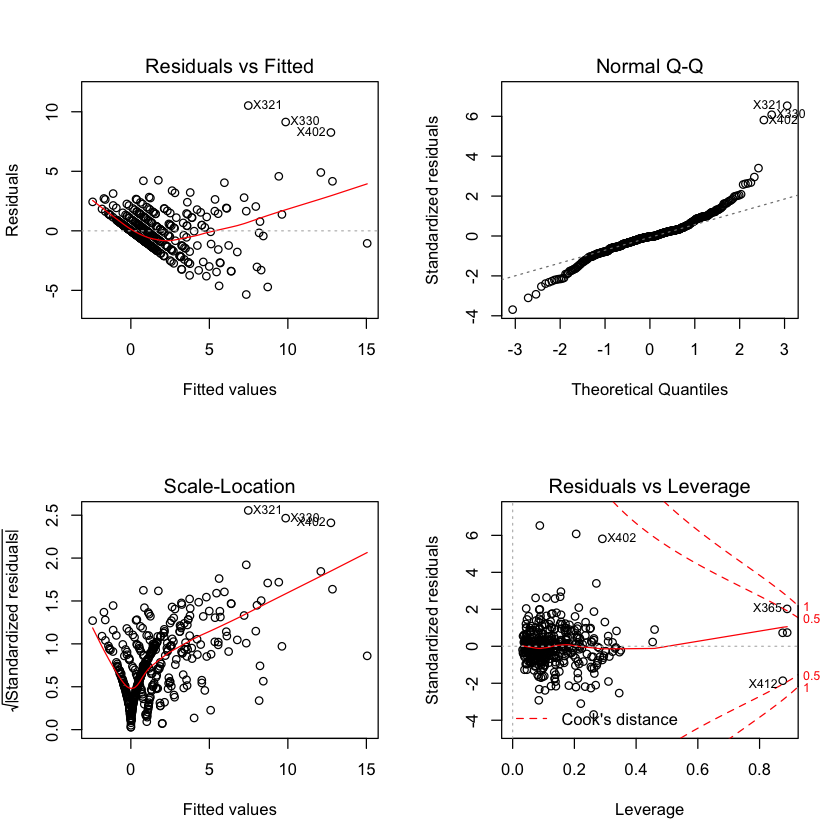

In [34]:
par(mfrow = c(2, 2))
plot(lm_fit$finalModel)

## Fixed Effects

Due to the panel data structure, I fitted generalized linear mixed models, such as the fixed effects (FE), random effects (RE) and pooled OLS model, and then used hypotheiss testing to compare which model is most appropriate. Unlike in OLS models fitted via maximizing the log-likelihood, in this case, we cannot use AIC as a metric to compare models. 

Since we have to model the relationship between the land cover characterstics (time-variant variables) and count data - number of bigfoot sightings, and the model does not a time-invariant variable (except for the adummy variable for state), I first tried the FE model. It only analyzes the net effect of variables that change across the decades by eliminating the impact of time-invariant characterstics. Furthermore, it presupposes that the time-invariant variables are uncorrelated with the other county-specific characterstics. The FE model is:


From the fixed effects model, all variables except for Wetlands are insignificant. The positive slopes of variables population, forest, snow.barren and dummy variable that captures the state of Washington imply that increasing the percent of county land covered with forest, wetlands, and snow or barren land raise the reported sightings of bigfoots. Furthermore, a person will see 0.988 (or estimately 1) more bigfoot in a county of Washington than that in Oregon. 

From the model, if the proportion of snow increases by 1 percent, the number of bigfoots reported would rise by 0.234. So, a 5 percent increase in the barren land will raise bigfoot sightings by 1.17, and a 20 percent rise will rise the counts by 4.68. Likewise, growing the forested region by 5 percent increases the bigfoot sightings by (2.467/100)* 5 = 0.12335. However, if forested region expands by about 40 percent,then we expect that the sightings of bigfoot will rise by 1.

Alternatively, if the proportion of county that is developed increases by 1 percent, then we expect that the reported sightings will diminish by -0.4751/100 = 0.004751 bigfoots. So, if the county is developed by 5 percent more, then it will substantially diminish the bigfoots sighted by 0.004751 * 5 = 0.02375. 

In [102]:
0.00475 * 5

[1] 0.02375

In [124]:
fixed = plm(Bigfoot ~  Population + Water  + Developed + Forest + Wetlands + Snow.Barren + 
            factor(State), 
                              data = bigfoot1, 
                              index = c('Decade'), model = 'within')
summary(fixed)

Oneway (individual) effect Within Model

Call:
plm(formula = Bigfoot ~ Population + Water + Developed + Forest + 
    Wetlands + Snow.Barren + factor(State), data = bigfoot1, 
    model = "within", index = c("Decade"))

Balanced Panel: n = 6, T = 75, N = 450

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-7.52321 -1.04698 -0.15532  0.71778 14.34981 

Coefficients:
                           Estimate  Std. Error t-value  Pr(>|t|)    
Population               6.1235e-06  6.6048e-07  9.2713 < 2.2e-16 ***
Water                   -1.5657e+01  5.6154e+00 -2.7882  0.005532 ** 
Developed               -4.7506e+00  2.3502e+00 -2.0213  0.043853 *  
Forest                   2.4674e+00  4.9209e-01  5.0142 7.754e-07 ***
Wetlands                 2.3042e-01  5.8442e+00  0.0394  0.968568    
Snow.Barren              2.3409e+01  7.3173e+00  3.1991  0.001479 ** 
factor(State)Washington  9.8801e-01  2.1311e-01  4.6361 4.695e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

## Random Effects

Unlike the assumption in the FE model, we assume that the variation across counties is random and serially uncorrelated with the counts of bigfoots. In contrast to the FE model where the intercept absorbs the time-invariant characterstics, the RE model can incorporate time-invariant variables such as distance and county characterstics given in the dataset.  

The random effects model is:

Having noticed from the summary statistics that Sasquatch enthusiasts have sighted more bigfoots in Washington than in Oregon, I added a distance variable called Seattle, which measures the distance from county centroid to Seattle in kilometers. Additionally, I incorporated a variable called SqMi, which measures a county's area in sqare miles. Both the variables are statistically significant. Other statistically significant variables are log_pop, Forest, and Wetlands. The coefficient of log_pop is 0.519, so if population increases by 1 percent, then the number of bigfoots sighted will rise very minutely by 0.519/100 = 0.00519. 

In [127]:
random = plm(Bigfoot ~  log_pop + Water + Developed + Forest + Agriculture + Wetlands + Snow.Barren + 
             Seattle + SqMi, # time-invariant (or distance) characterstics, 
                              data = bigfoot1, 
                              index = c('Decade'), model = 'random')
summary(random)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = Bigfoot ~ log_pop + Water + Developed + Forest + 
    Agriculture + Wetlands + Snow.Barren + Seattle + SqMi, data = bigfoot1, 
    model = "random", index = c("Decade"))

Balanced Panel: n = 6, T = 75, N = 450

Effects:
                 var std.dev share
idiosyncratic 4.7661  2.1831 0.876
individual    0.6726  0.8201 0.124
theta: 0.7062

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-4.31015 -1.08556 -0.23543  0.68695 16.36867 

Coefficients:
               Estimate  Std. Error z-value  Pr(>|z|)    
(Intercept) -2.1149e+00  1.0559e+00 -2.0030  0.045179 *  
log_pop      4.7359e-01  1.1143e-01  4.2499 2.138e-05 ***
Water       -9.1405e+00  5.7957e+00 -1.5771  0.114769    
Developed   -7.6896e-01  2.8370e+00 -0.2710  0.786353    
Forest       2.1490e+00  7.8726e-01  2.7297  0.006340 ** 
Agriculture -1.5049e+00  1.0796e+00 -1.3940  0.163328    
Wetlands    -1.9349e+01  6.1805e+



To choose between the FE and RE models, I performed the Hausman Test, which measures the hypothesis that cov(αi, Xit) = 0
H0 : cov(αi, Xit) = 0 => preferred model is RE
HA : cov(αi, Xit) =/ 0 => use FE model

Since the p-value of 2.2e-16 is much less than the 0.05 significance level, we reject the null hypothesis, and select the alternative i.e. FE model. However, in general, we have to be cautious of bias originating (if any) due to omitted factors that vary across counties, but not over time, and other omitted factors that may also vary across time, biasing the estimates. 

In [128]:
phtest(fixed, random)


	Hausman Test

data:  Bigfoot ~ Population + Water + Developed + Forest + Wetlands +  ...
chisq = 711.53, df = 5, p-value < 2.2e-16
alternative hypothesis: one model is inconsistent


## Pooled OLS

Next, I fitted a pooled ordinary least squares (POLS) model and expanded the RE model by interacting wetlands with agriculture, and adding a polynomial term for Snow.Barren, resulting in statistically significant estimates. Whilst I tired other polynomials and interactions manually, they were not statistically significant and reduced the adjusted R square further. 

In [129]:
pool = plm(Bigfoot ~  log_pop + Water + Developed + Forest + Snow.Barren + 
           factor(State) + Wetlands * Agriculture + poly(Snow.Barren, 2), 
                              data = bigfoot1, 
                              index = c('Decade'), model = 'pooling')
summary(pool)

Pooling Model

Call:
plm(formula = Bigfoot ~ log_pop + Water + Developed + Forest + 
    Snow.Barren + factor(State) + Wetlands * Agriculture + poly(Snow.Barren, 
    2), data = bigfoot1, model = "pooling", index = c("Decade"))

Balanced Panel: n = 6, T = 75, N = 450

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-5.07581 -1.18589 -0.37411  0.65180 16.04597 

Coefficients: (1 dropped because of singularities)
                          Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)               -6.85328    1.04178 -6.5785 1.355e-10 ***
log_pop                    0.72173    0.10634  6.7872 3.718e-11 ***
Water                    -11.53931    6.31027 -1.8287  0.068129 .  
Developed                 -1.15487    2.79868 -0.4126  0.680066    
Forest                     1.25713    0.69871  1.7992  0.072672 .  
Snow.Barren               21.00099    8.52218  2.4643  0.014111 *  
factor(State)Washington    1.08749    0.24959  4.3571 1.643e-05 ***
Wetlands                   2.258

Moreover, I conducted the Breusch-Pagan Lagrange Multiplier test which helps select between the RE and the POLS model. The null hypothesis is that variances acorss counties are 0, signifying no panel effects. In this case, the POLS model would be sufficient. The results of the Breuch Pagan LM test yield a p-value of 2.2e-16, so we reject the null hypothesis and conclude that there is significant difference across counties, making the RE model more appropriate.This model does not distinguish between estimates of the same counties across across different decades, and is typically well-suited for cross-sectional data.  

In [130]:
# Breusch-Pagan Lagrange Multiplier for random effects. Null is no panel effect (i.e. OLS better).
plmtest(pool, type=c("bp"))


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  Bigfoot ~ log_pop + Water + Developed + Forest + Snow.Barren +  ...
chisq = 352.81, df = 1, p-value < 2.2e-16
alternative hypothesis: significant effects


Additionally, I conducted the Breuch-Pagan test to check for the presence of heteroskedastic errors in the FE model. The null hypothesis is that the errors are homoskedastic. A very small p-value of 2.2e-16 rejects the null hypothesis, so we conclude that the errors are heteroskadastic. To control for non-constant variance in FE, I calculated heteroskedasticity consistent coefficients. For each slope coefficient, I computed the clustered standard error for all panel models, which allows for autocorrelated and heteroskedastic errors within a county but not across counties.

In [131]:
bptest(fixed, data = bigfoot1, studentize=F) # Testing for heteroskedasticity


	Breusch-Pagan test

data:  fixed
BP = 464.32, df = 7, p-value < 2.2e-16


## Poisson model with random intercepts 

Finally, I fit a type of generalized linear mixed model, called poisson model. Without any offset, I fit a random intercept only poisson model wherein there are six different intercepts corresponding to each decade. The model is:

In [200]:
# Poisson model with random intercepts [summary in APPENDIX]

pois = glmer(Bigfoot ~  log_pop + Water + Developed + Forest + Snow.Barren + Seattle + (1 + Decade|State),
            family = poisson, data = bigfoot1)
summary(pois)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: Bigfoot ~ log_pop + Water + Developed + Forest + Snow.Barren +  
    Seattle + (1 + Decade | State)
   Data: bigfoot1

     AIC      BIC   logLik deviance df.resid 
  1233.4   1348.4   -588.7   1177.4      422 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6110 -0.7115 -0.3465  0.3330  7.3405 

Random effects:
 Groups Name            Variance Std.Dev. Corr                         
 State  (Intercept)      7.913   2.813                                 
        Decade1968-1977  7.309   2.703    -1.00                        
        Decade1978-1987  7.659   2.768    -1.00  1.00                  
        Decade1988-1997  8.881   2.980    -1.00  1.00  1.00            
        Decade1998-2007 14.377   3.792    -0.99  0.99  1.00  0.99      
        Decade2008-2017  6.237   2.497    -0.97  0.97  0.99  0.98  1.00
Number of obs: 450, groups:  State, 2

Through a visual insepction of a caterpillar plot below, for each state the random effects model shows different intercepts for each decade.

$State


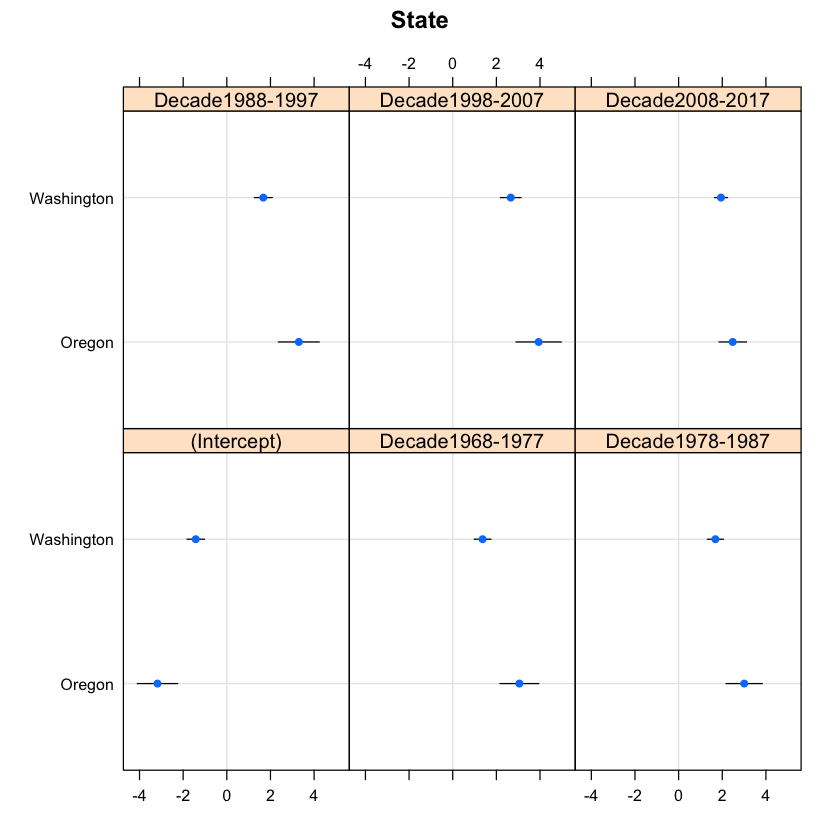

In [201]:
## Caterpillar plot
lattice::dotplot(ranef(pois, postVar = TRUE))

Below I have simulated a poisson random variable where the mean is equal to the third model's fitted mean. Then, I plotted the residuals from the simulated data. The residual vs fitted plot from the simulated looks qualitatively very similar to that of the model fit from the true data. 

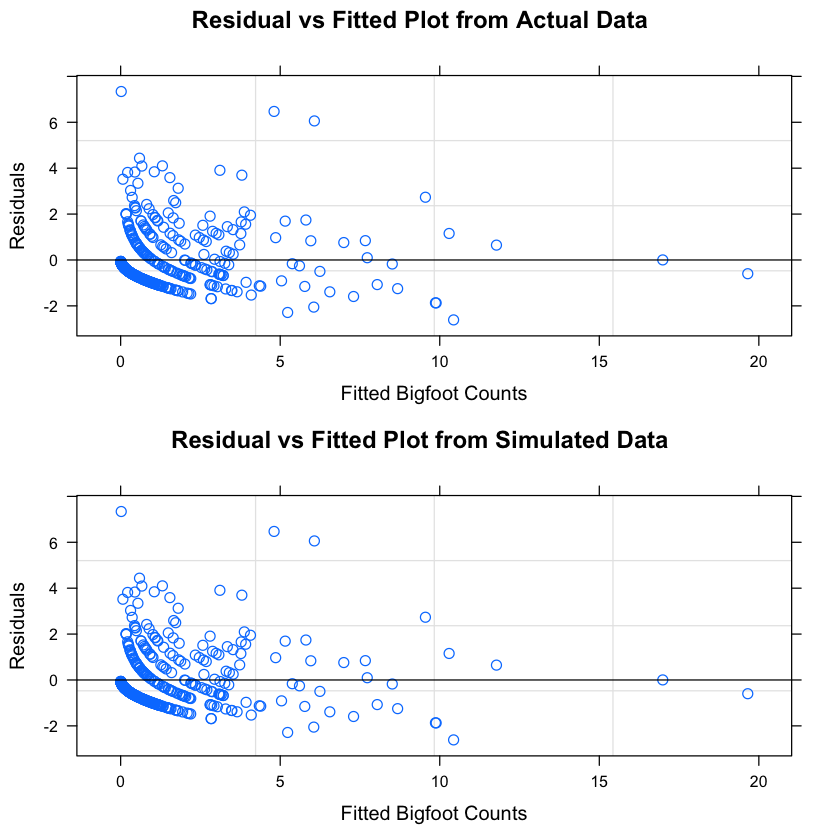

In [215]:
muhat = predict(pois ,type="response") # results in poisson count data
ysim=rpois(length(muhat),lambda=muhat)

fit.sim = glmer(Bigfoot ~  log_pop + Water + Developed + Forest + Snow.Barren + Seattle + (1 + Decade|State),
            family = poisson, data = bigfoot1)

# Residuals  vs fitted plot from actual data
res_actual = plot(pois, ylab = "Residuals", xlab = 'Fitted Bigfoot Counts', 
       main = "Residual vs Fitted Plot from Actual Data")

# Residuals  vs fitted plot from simulated data
res_pred = plot(fit.sim, ylab = "Residuals", xlab = 'Fitted Bigfoot Counts', 
     main = "Residual vs Fitted Plot from Simulated Data") 

require(gridExtra)
grid.arrange(res_actual, res_pred )

In [204]:
cov1 = vcovHC(fixed, type = "HC0")
robust.se1 = sqrt(diag(cov1)) # heteroskedasticity robust standard errors 

cov2 = vcovHC(random, type = "HC0")
robust.se2 = sqrt(diag(cov2)) # heteroskedasticity robust standard errors 

cov3 = vcovHC(pool, type = "HC0")
robust.se3 = sqrt(diag(cov3)) # heteroskedasticity robust standard errors 

stargazer(fixed,random,pool,pois, type = "text", se=list(robust.se1, robust.se2 , robust.se3),
          column.labels=c("Fixed Effects", "Random Effects" , "Pooled OLS", "Poisson"),
          intercept.bottom = FALSE, title="Panel Regression Results with Robust Standard Errors")


Panel Regression Results with Robust Standard Errors
                                                       Dependent variable:                                
                        ----------------------------------------------------------------------------------
                                                             Bigfoot                                      
                                                     panel                                 generalized linear   
                                                    linear                                   mixed-effects      
                             Fixed Effects      Random Effects        Pooled OLS             Poisson      
                                  (1)                (2)                 (3)                   (4)        
----------------------------------------------------------------------------------------------------------
Population                    0.00001***                                      

In [228]:
0.234 * 5

[1] 1.17

## Predicted counts of bigfoot from the best model

From the best model (FE) chosen from the Hausman test, I first predicted the count of bigfoot sightings for each county in Washington and Oregon, and found that the results were very similar to the actual counts in the dataset. 

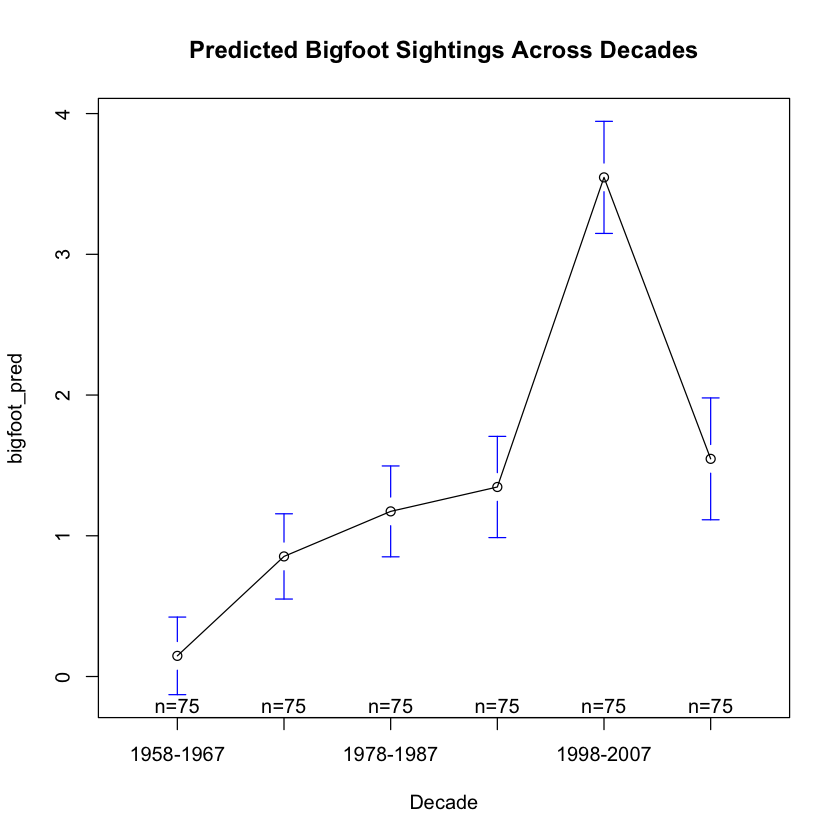

In [44]:
## produce a dataset of prediction, added to the group means
pred_decade = bigfoot %>% 
  mutate(y = Bigfoot) %>% 
  group_by(Decade) %>% 
  transmute(y_mean = mean(y),
            y = y, 
            Decade = Decade) %>% 
  ungroup() %>% 
  mutate(bigfoot_pred = predict(fixed) + y_mean) %>% 
  select(-y_mean)

# plotmeans draw a 95% confidence interval around the means

plotmeans(bigfoot_pred ~ Decade, main="Predicted Bigfoot Sightings Across Decades", data = pred_decade)

In [46]:
sum_pred = pred_decade %>% 
  group_by(Decade) %>% 
  summarize(
            min = min(bigfoot_pred),
            q1 = quantile(bigfoot_pred, 0.25),
            mean = mean(bigfoot_pred),
            q3 = quantile(bigfoot_pred, 0.75),
            max = max(bigfoot_pred)) %>% as.data.frame()

stargazer(sum_pred, type = "text", summary = FALSE,
         title ="Summary Statistics of the Predicted Number of Bigfoots Sighted by Decade in Washington and Oregon")

`summarise()` ungrouping output (override with `.groups` argument)




Summary Statistics of the Predicted Number of Bigfoots Sighted by Decade in Washington and Oregon
   Decade    min     q1   mean   q3    max  
--------------------------------------------
1 1958-1967 -1.810 -0.738 0.147 0.705 5.507 
2 1968-1977 -1.182 -0.036 0.853 1.360 7.502 
3 1978-1987 -0.967 0.229  1.173 1.616 8.446 
4 1988-1997 -0.875 0.348  1.347 1.795 10.006
5 1998-2007 1.200  2.510  3.547 4.051 13.435
6 2008-2017 -0.902 0.461  1.547 2.126 12.523
--------------------------------------------


The summary statistics of number of predicted signtings in Washinton and Oregon, the in-sample predictions are higher for Washington as expected and, the root mean square error in datase was 2.0824.

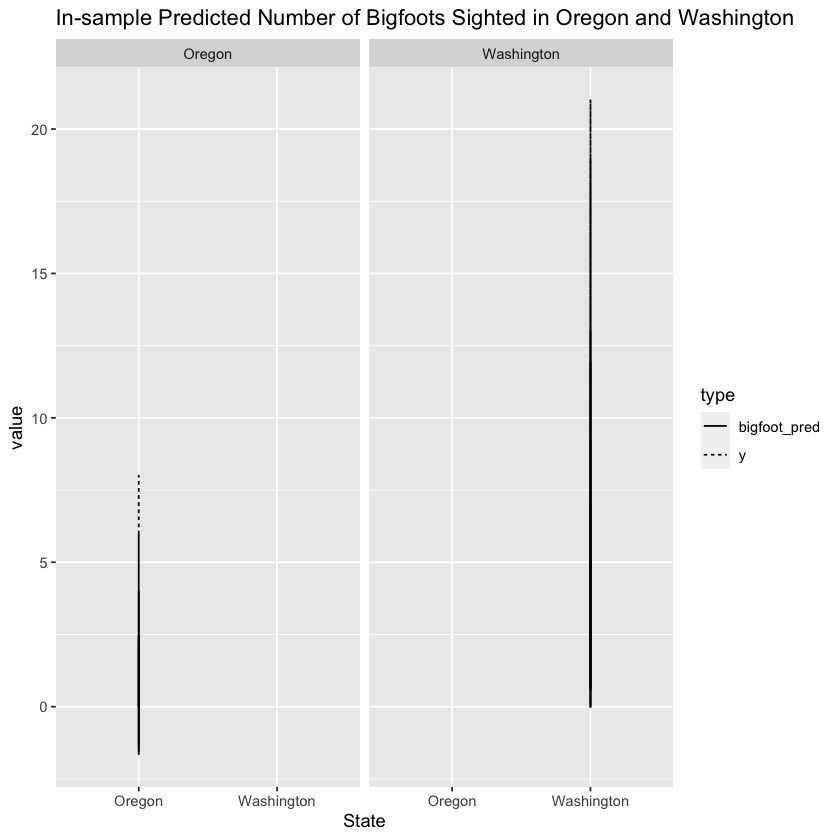

In [57]:
## produce a dataset of prediction, added to the group means
pred_state = bigfoot %>% 
  mutate(y = Bigfoot) %>% 
  group_by(State) %>% 
  transmute(y_mean = mean(y),
            y = y, 
            State = State) %>% 
  ungroup() %>% 
  mutate(bigfoot_pred = predict(fixed) + y_mean) %>% 
  select(-y_mean)

#  plot it
pred_state %>% 
  gather(type, value, y, bigfoot_pred) %>% 
  
  ggplot(aes(x = State, y = value, linetype = type)) +
  geom_line() +  
  #scale_fill_manual(name="Bigfoots Sighted",labels=c("Predicted", "Actual") ) +
  facet_wrap(~State) +
  ggtitle("In-sample Predicted Number of Bigfoots Sighted in Oregon and Washington") 

In [59]:
rmse(bigfoot$Bigfoot, pred_decade$bigfoot_pred)

[1] 2.087526

Finally, using the appropriate model, I predicted the number of bigfoot sightings for each county in the state of Idaho in 2008-2017. After obsering a few negative value of predicted counts, I set a floor value for all fitted values. That is, I set the value of 0, if the predicted count was negative, and then created a scatterplot for the predicted counts in each county. The scatterplot connotes a random spead of predicted counts across counties ranging from 0 to 3. 

In [60]:
idaho1 = idaho %>% mutate(log_pop = log(Population))
idaho1[idaho1 == -Inf] = 0
idaho1[idaho1 == 'NAN'] = 0

pred_idaho = prediction::prediction(random, data = idaho1)

# set the floor of all fitted values to 0, if they are negatives
pred_idaho$fitted[pred_idaho$fitted < 0] = 0

# Writing covid1 data to a csv file
write_csv(pred_idaho, path = "pred_idaho.csv")

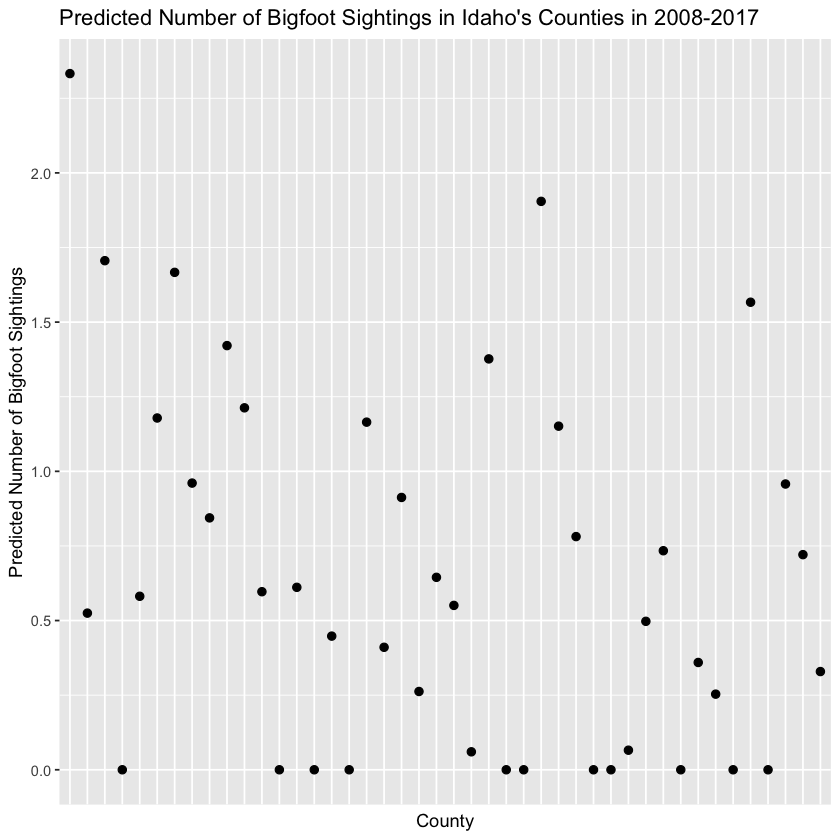

In [66]:
# Plot the predicted bigfoots sightings in Idaho
ggplot(data = pred_idaho, aes(x = County , y = fitted)) +
  geom_point(size = 2) +
  ggtitle("Predicted Number of Bigfoot Sightings in Idaho's Counties in 2008-2017") +
  xlab("County") + ylab("Predicted Number of Bigfoot Sightings") +      
  theme(
      axis.text.x=element_blank(),
      axis.ticks.x=element_blank()
  )

#kitt = bigfoot %>% filter(County == 'Kittitas')

## Conclusion

Thus, if the tourism board for Kittitas County in Washington would like to increase the number of Bigfoot sightings, it would be wise to expand the percent of barren and snow-clad land, forested region and shrink the percent of developed region.

## References

https://www.princeton.edu/~otorres/Panel101R.pdf

https://cran.r-project.org/web/packages/plm/vignettes/plmPackage.html